# Applicability of Digital Filters

### Comparing all filters included by default in `empymod` for the Hankel transform.

In the figures, non-acceptable relative errors (above 1 %) are red.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0, epsilon_0

import empymod as epm
epm.set_minimum(min_off=1e-30)

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## Deep water, shallow water, and land case

### Generate data

In [3]:
filt = ['kong_61_2007', 'kong_241_2007',
        'key_101_2009', 'key_201_2009', 'key_401_2009',
        'anderson_801_1982',
        'key_51_2012', 'key_101_2012', 'key_201_2012',
        'wer_201_2018']

In [4]:
# Offsets from 50 m to 20 km, logarithmically
x = np.logspace(np.log10(50/200), 2, 50)*200

# Frequencies from 0.01 Hz to 10 Hz, logarithmically
freqs = np.logspace(-2, 1, 50)

# Resistivities of lower half-space
res = [1, 10, 100, 1000]

# Source and receiver depths for the three cases
zsrc = [10, 1990, 0.5]
zrec = [100, 2000, 0.8]

# Water depths and resistivity for deep/shallow cases
wdepth = [400, 2000]
wres = 0.3

# General input parameters
inp = {'ab': 11, 'freqtime': freqs, 'verb': 1,}  

# Pre-allocate arrays for all three models, 4 resistivities
amp = np.zeros((3, len(freqs), len(x), 4))
err = np.zeros((len(filt), 3, len(freqs), len(x), 4))

# Loop over the three cases
for i, name in enumerate(['deep', 'shallow', 'land']):
    
    # Update model
    inp['src'] = [0, 0, zrec[i]]
    inp['rec'] = [x, x*0, zsrc[i]]
    if i < 2:
        inp['depth'] = [0, wdepth[i]]
        inp['res'] = [2e14, wres, -1]  # -1: we'll update later
        inp['epermH'] = [0, 1, 1]
        inp['epermV'] = [0, 1, 1]
    else:
        inp['depth'] = [0]
        inp['res'] = [2e14, -1]  # -1: we'll update later
        inp['epermH'] = [0, 1]
        inp['epermV'] = [0, 1]

    # Loop over 4 lower halfspace resistivities
    for ii, ires in enumerate(res):

        # Update lower halfspace resistivity
        inp['res'][-1] = ires

        # Calculate responses
        qwe = epm.dipole(ht='qwe', **inp)
        amp[i, :, :, ii] = np.log10(np.abs(qwe))
        
        for fi, fname in enumerate(filt):
            dlf = epm.dipole(htarg=fname, **inp)
            # Calculate relative error
            error = np.abs((dlf-qwe)/qwe)

            # Store analytical amplitude and relative error
            err[fi, i, :, :, ii] = np.log10(error)

* WARNING :: Hankel-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.
* WARNING :: Hankel-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.
* WARNING :: Hankel-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.


### Plot relative error

In [5]:
# pcolor needs start and endpoints, not actual points (midpoints)
xdif = (np.log10(x[1])-np.log10(x[0]))/2
xax = np.r_[np.log10(x/1000)-xdif, np.log10(x[-1]/1000)+xdif]
fdif = (np.log10(freqs[1])-np.log10(freqs[0]))/2
fax = np.r_[np.log10(freqs)-fdif, np.log10(freqs[-1])+fdif]

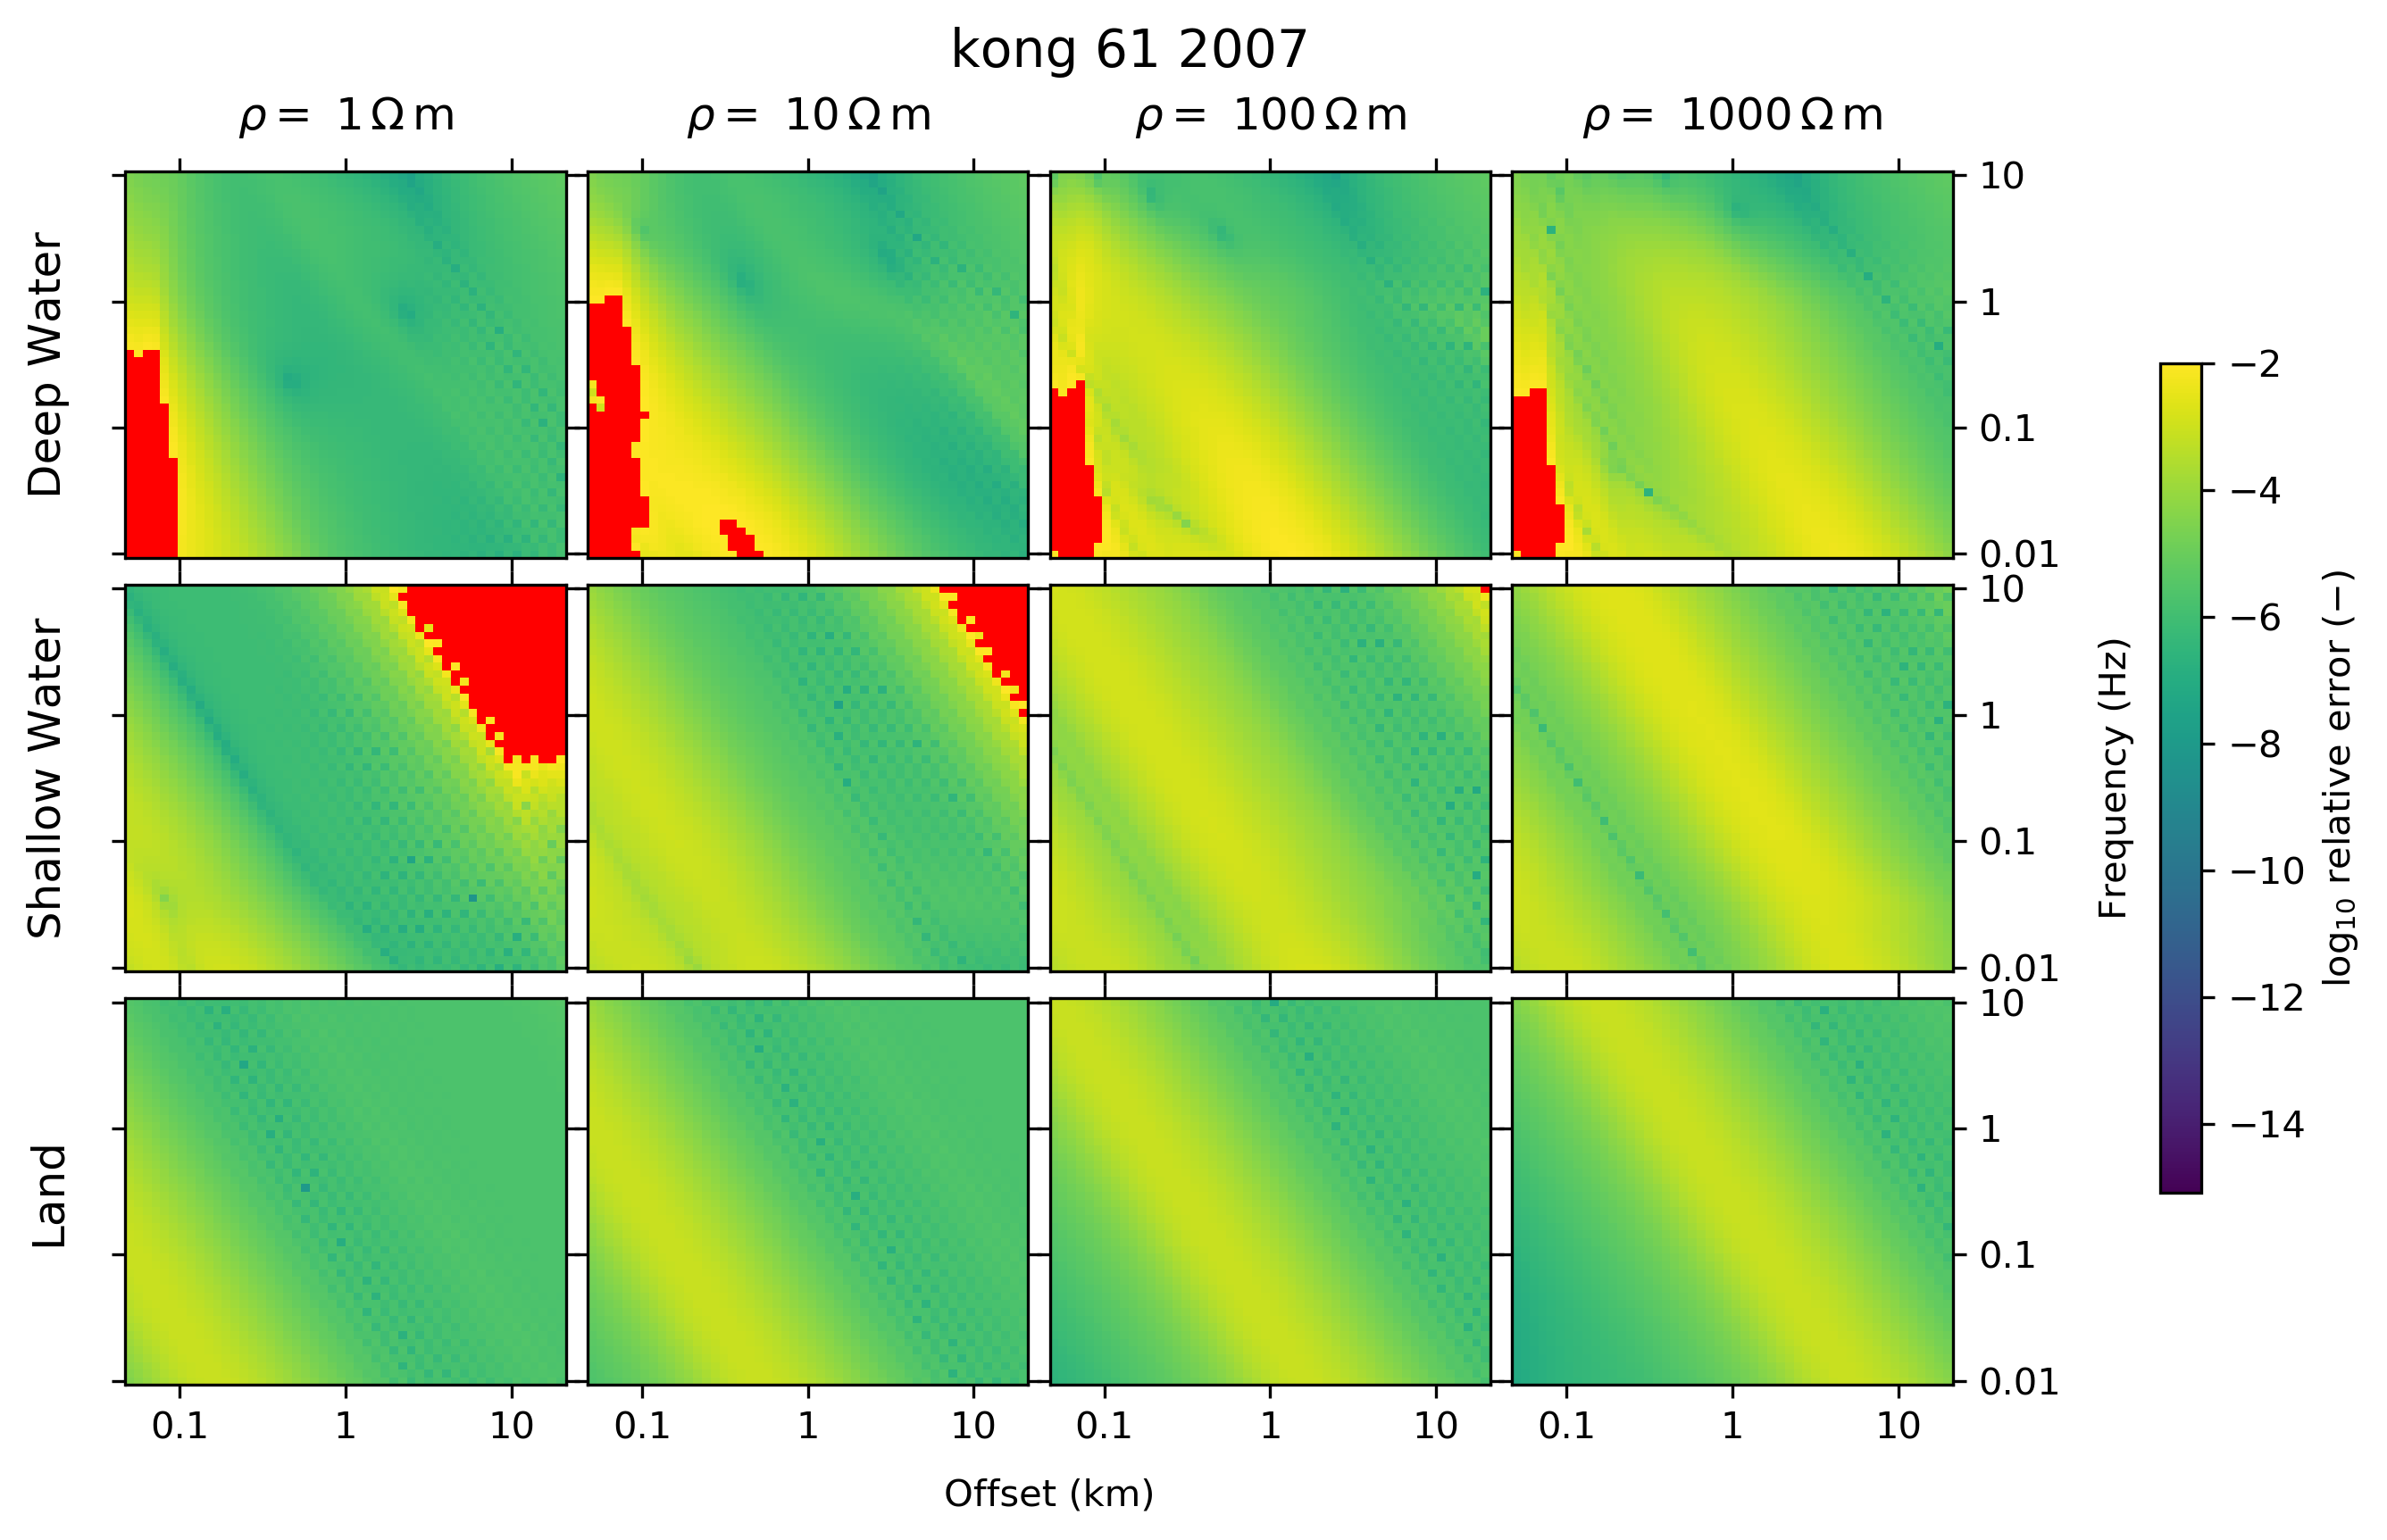

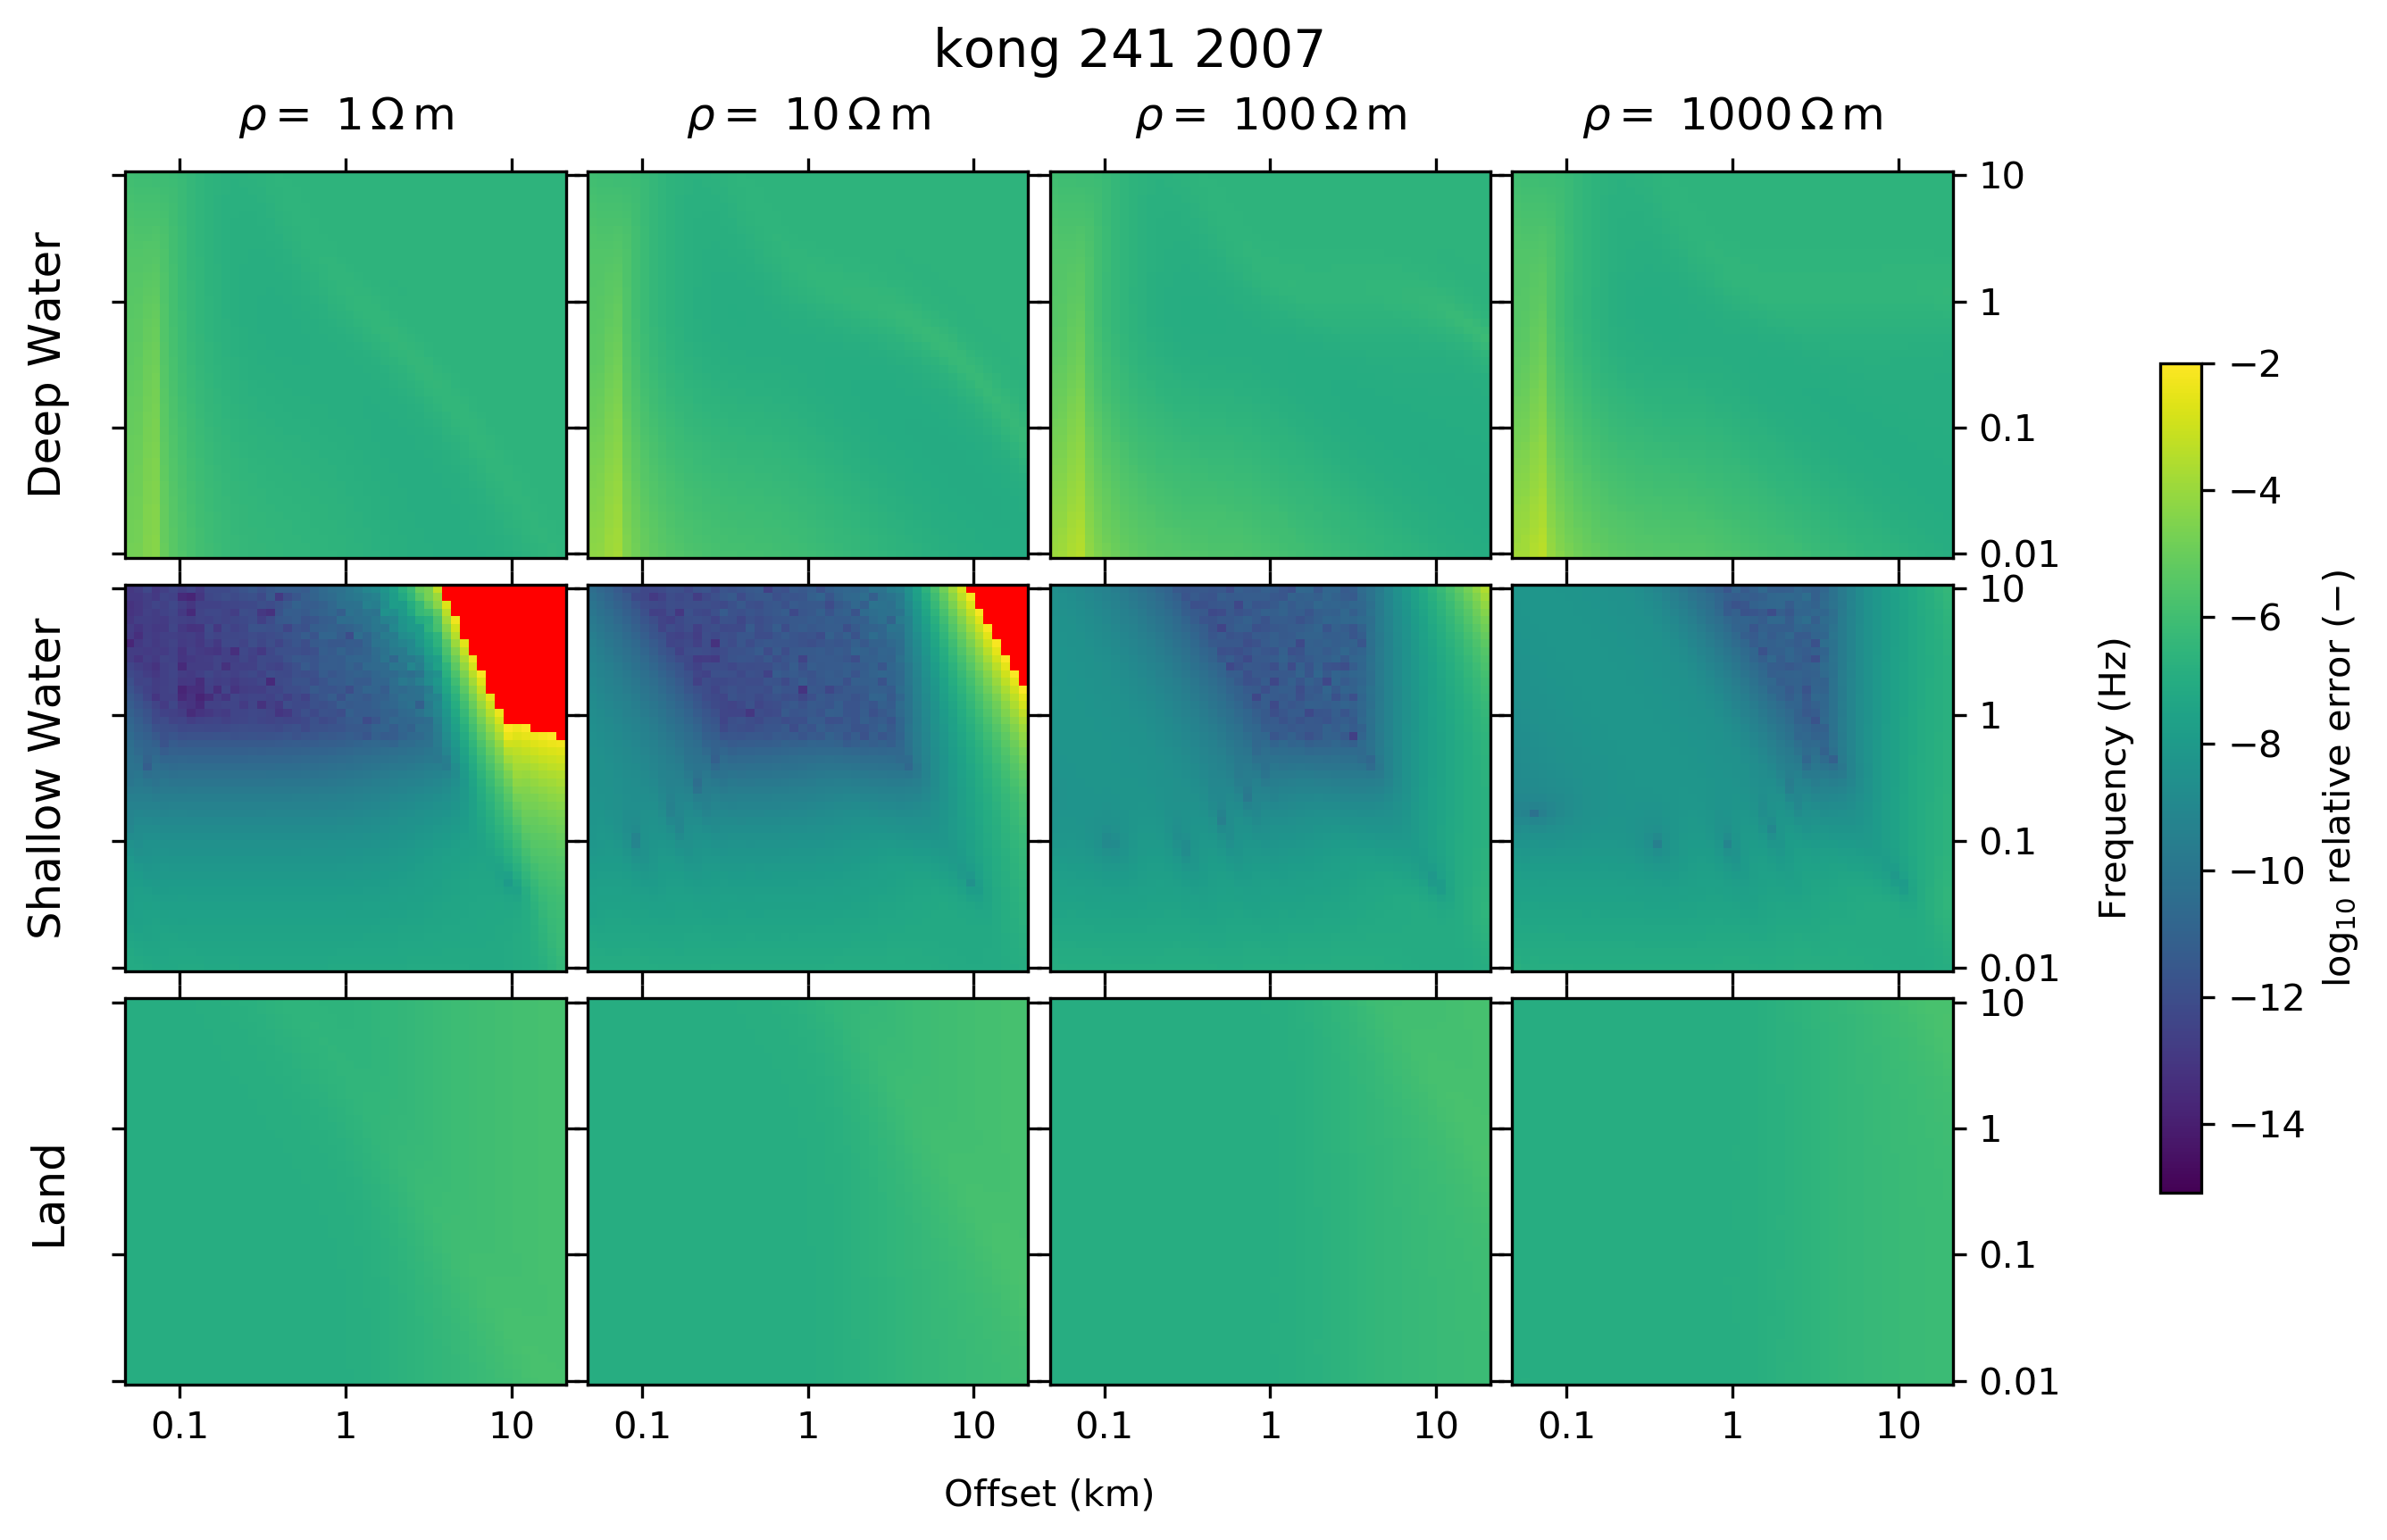

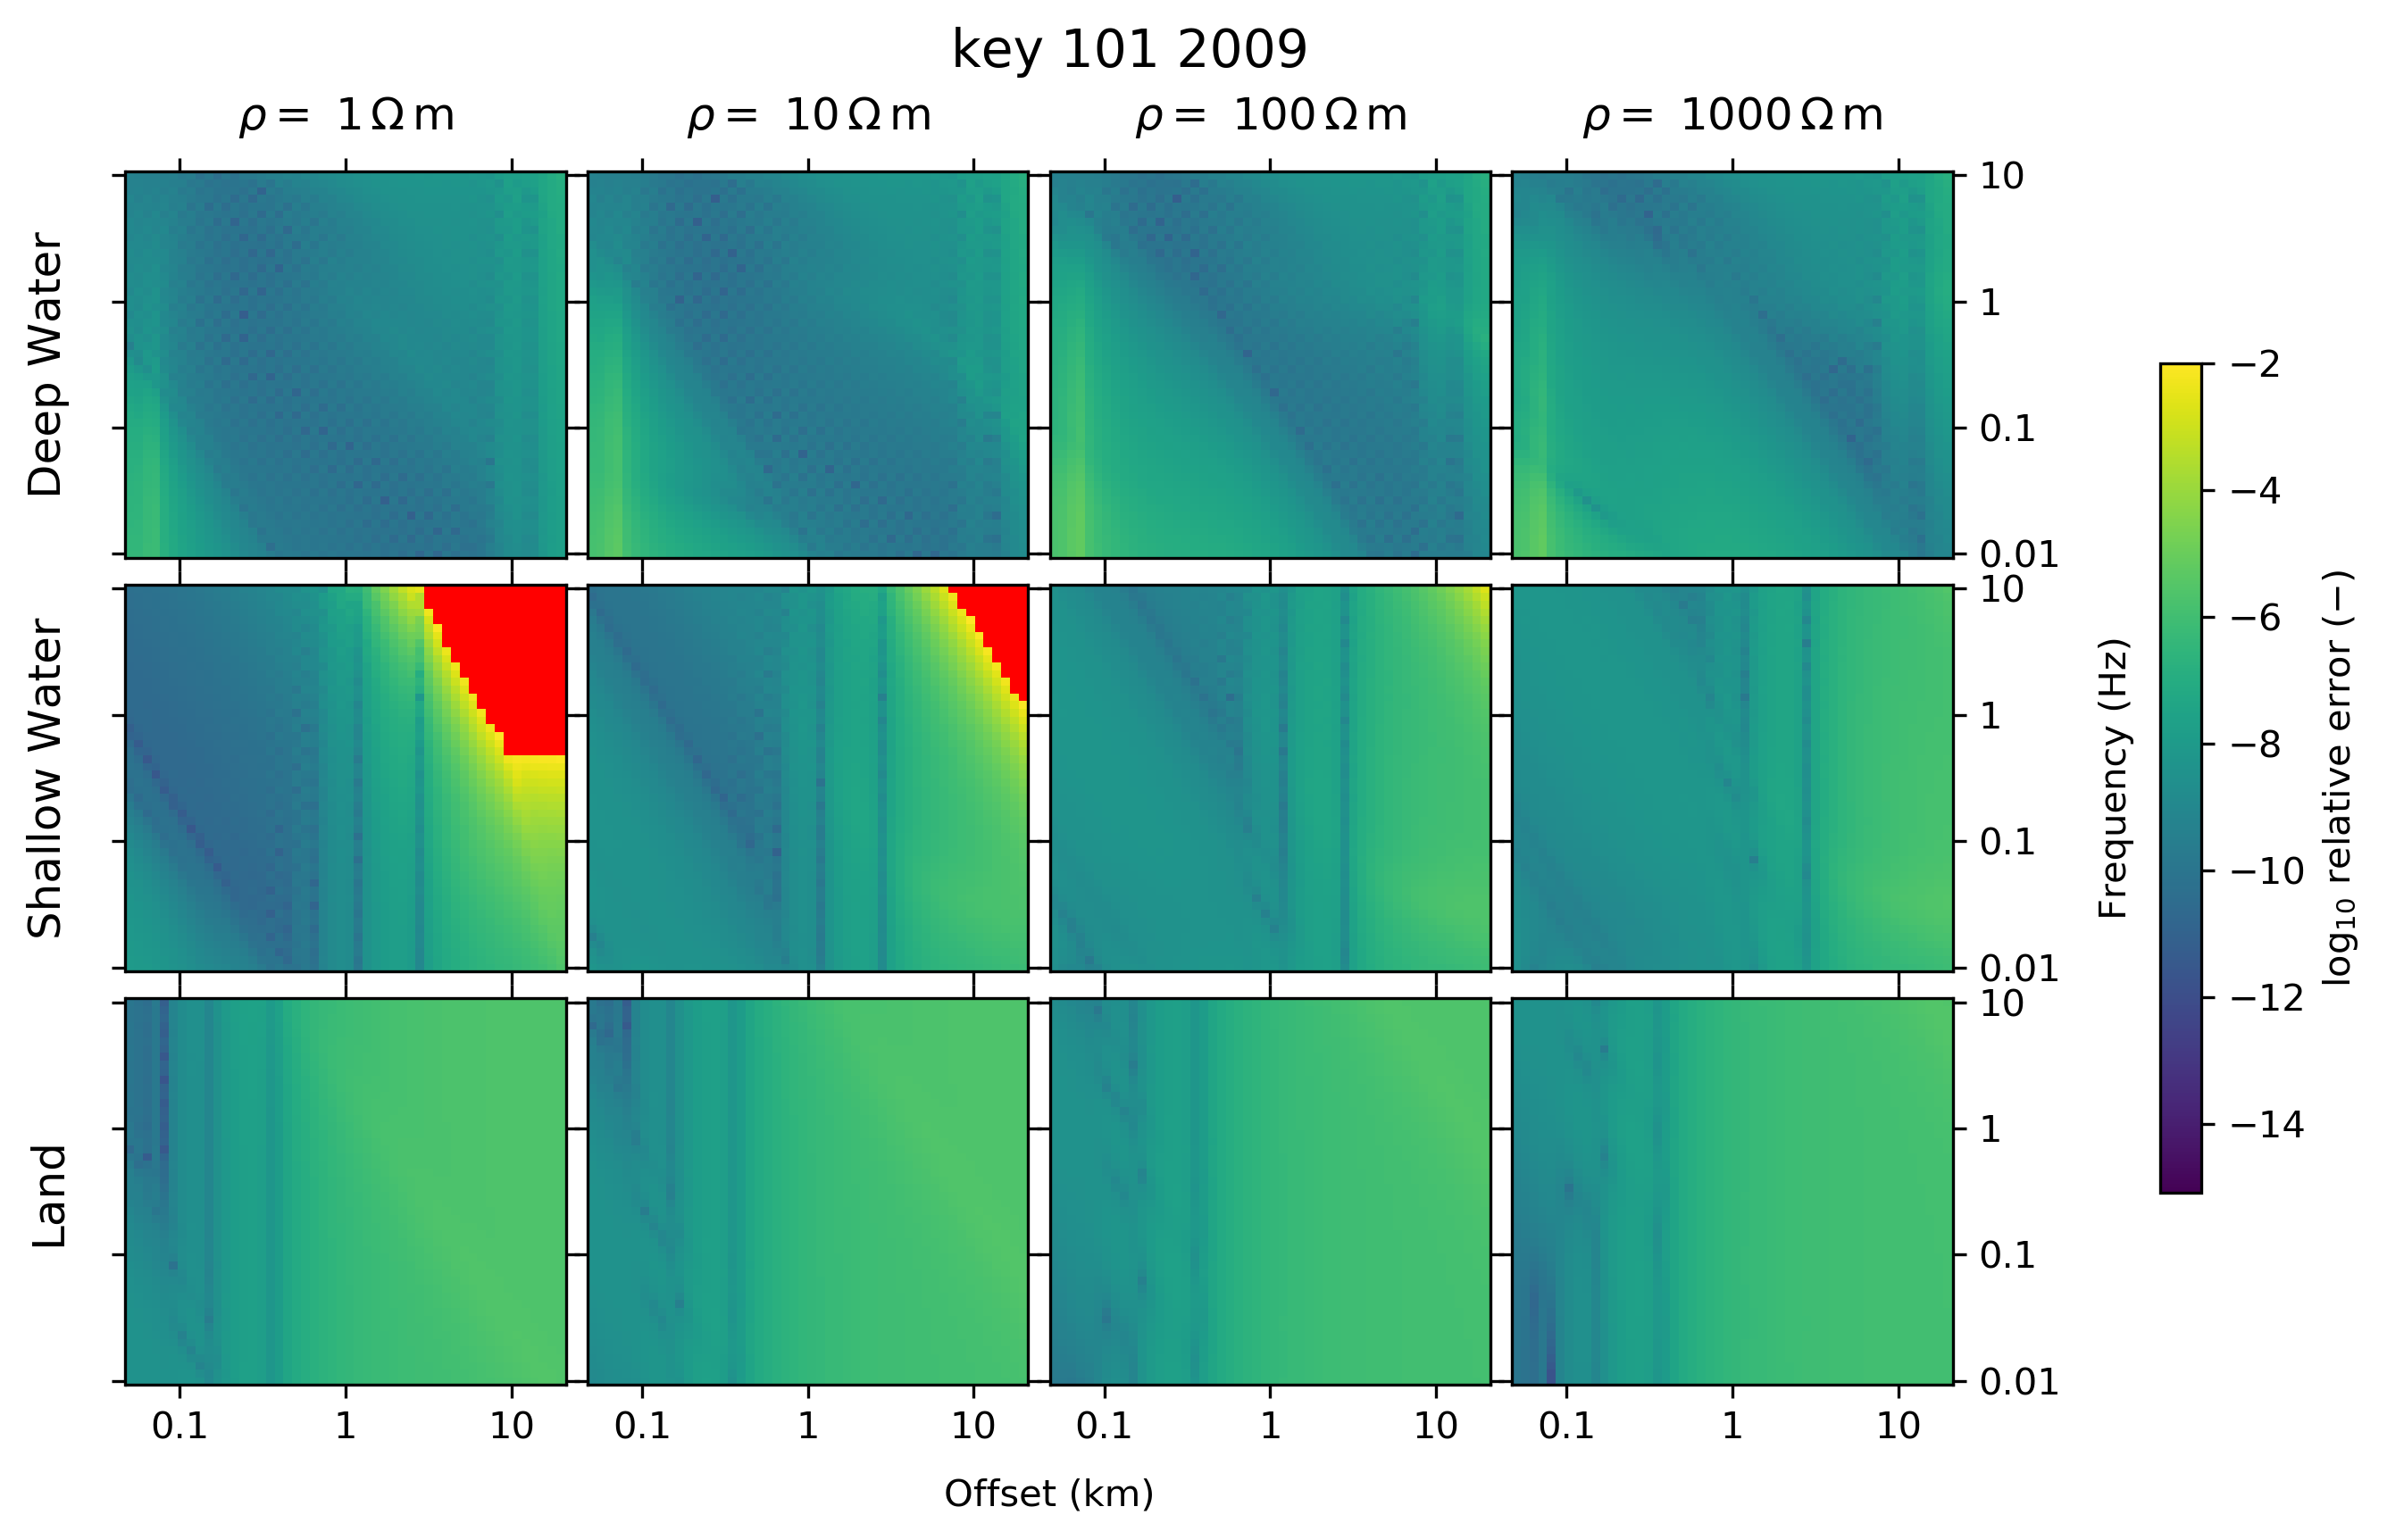

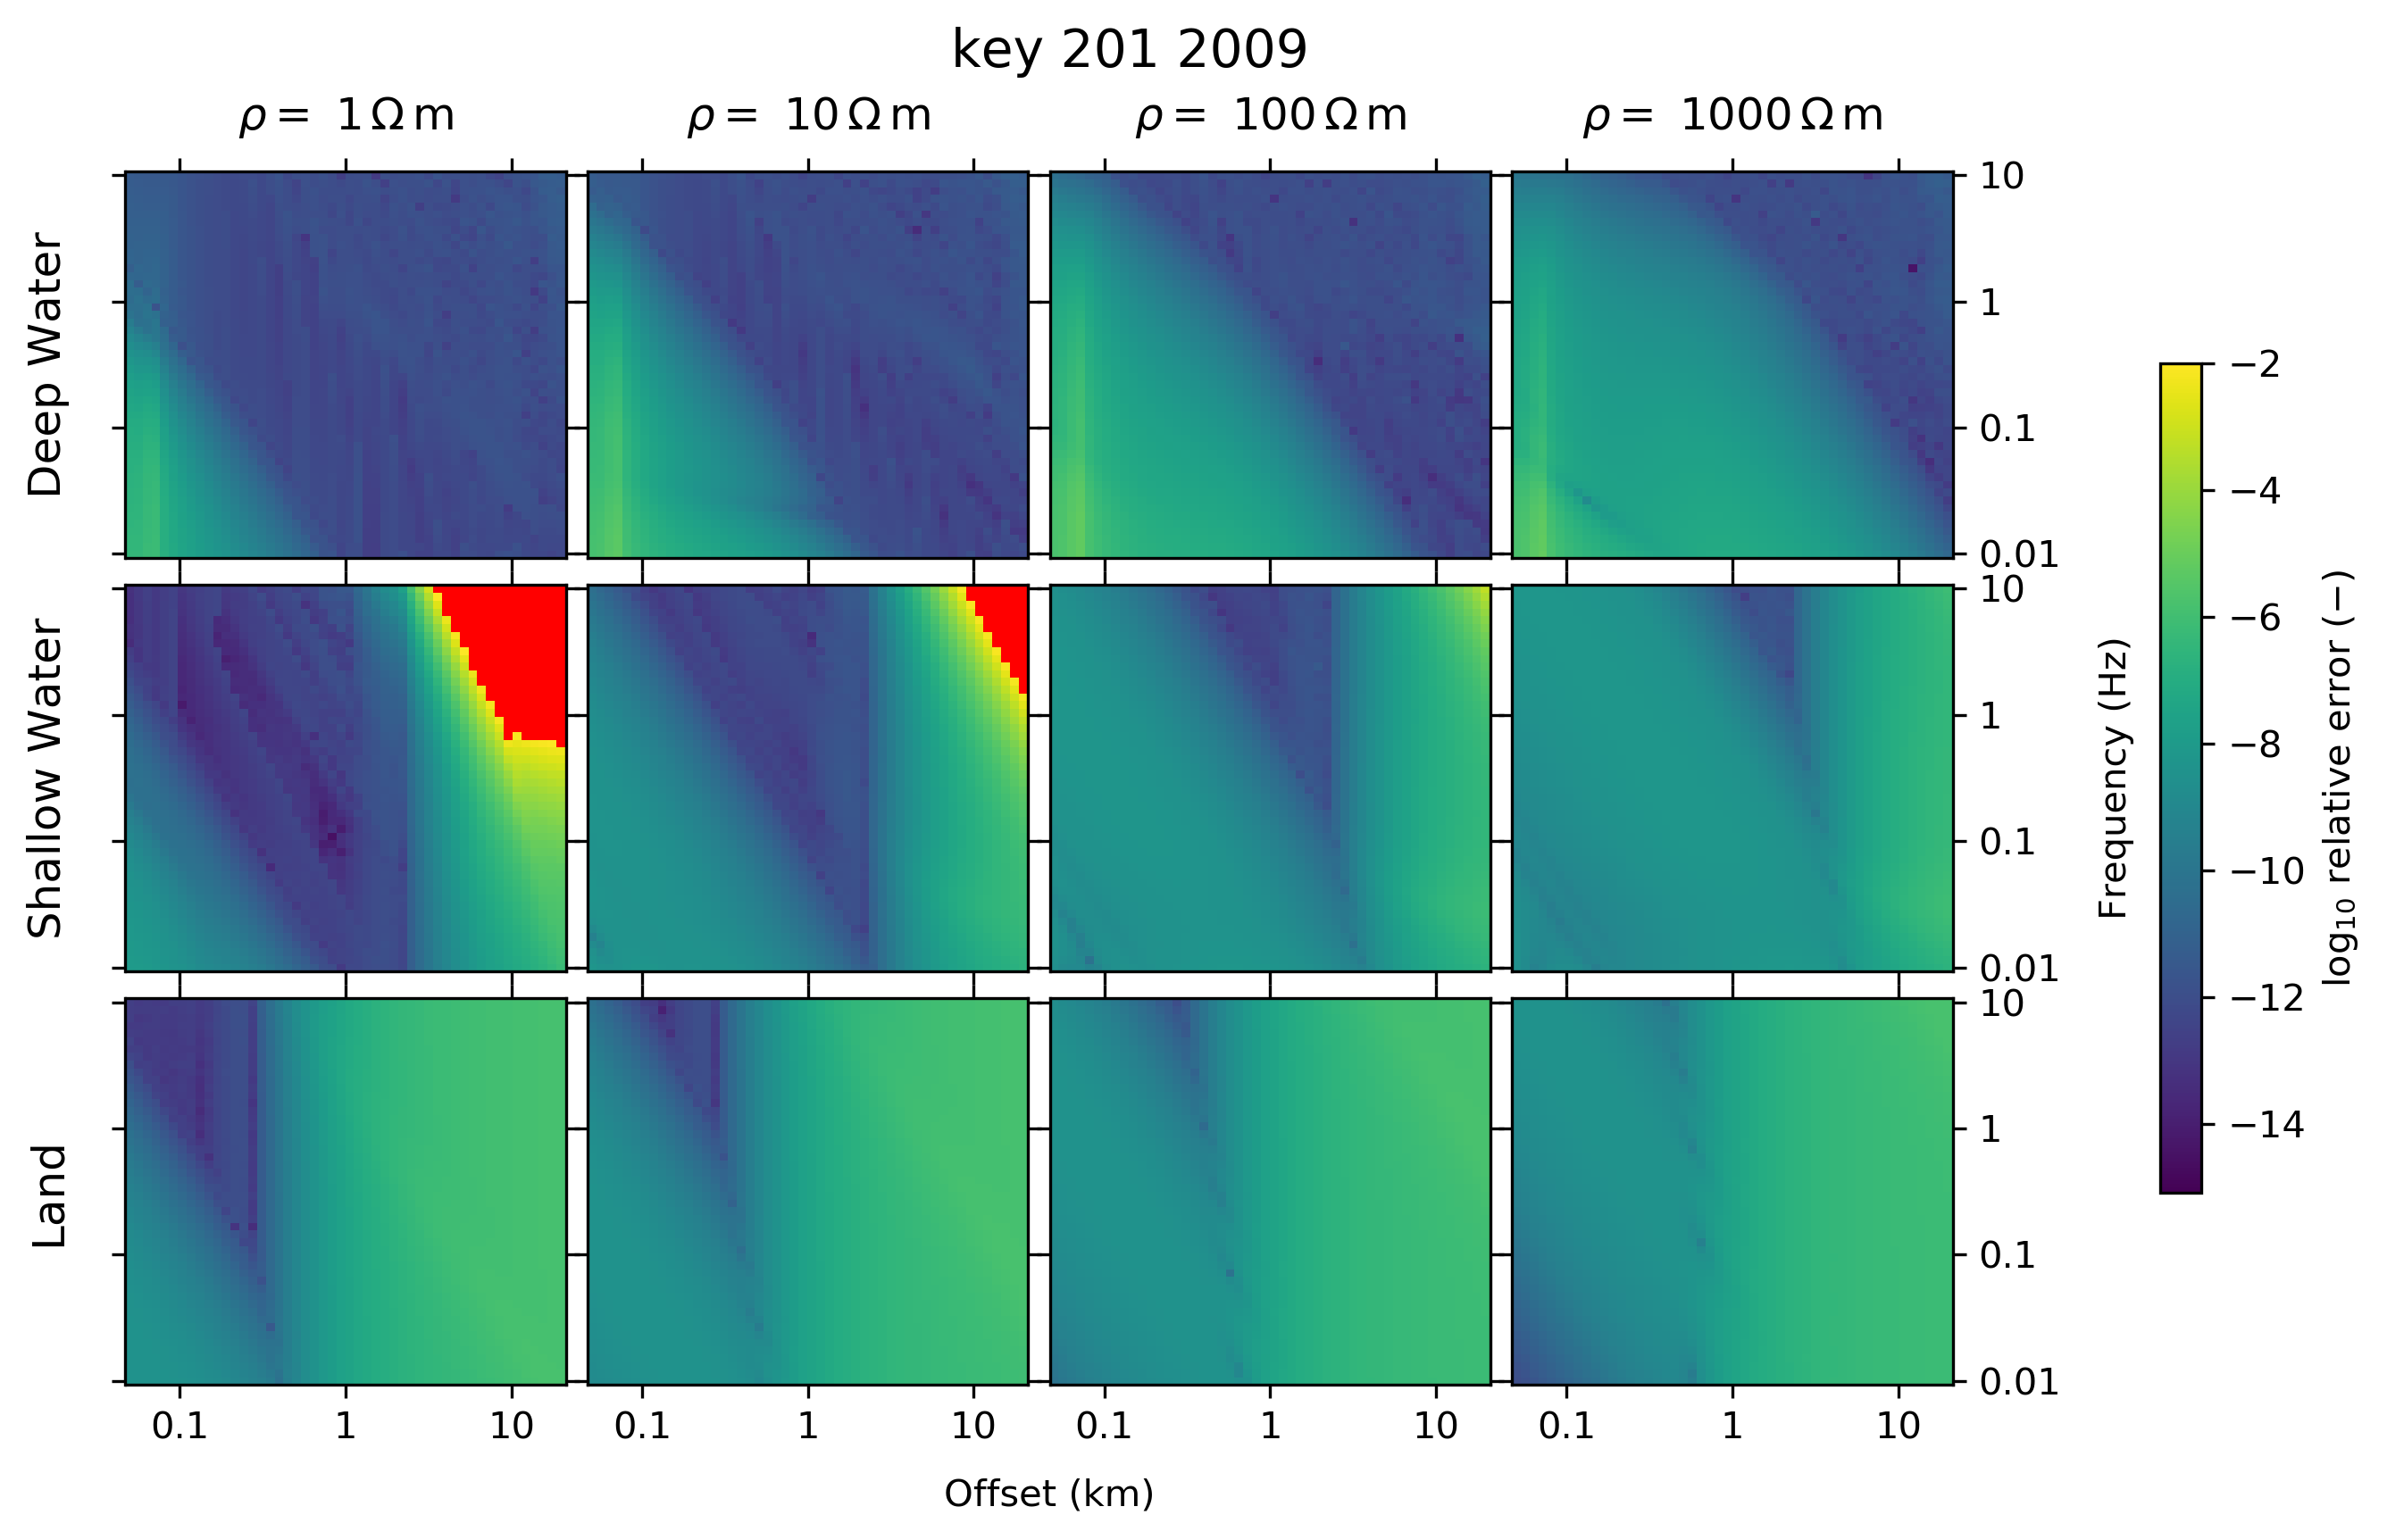

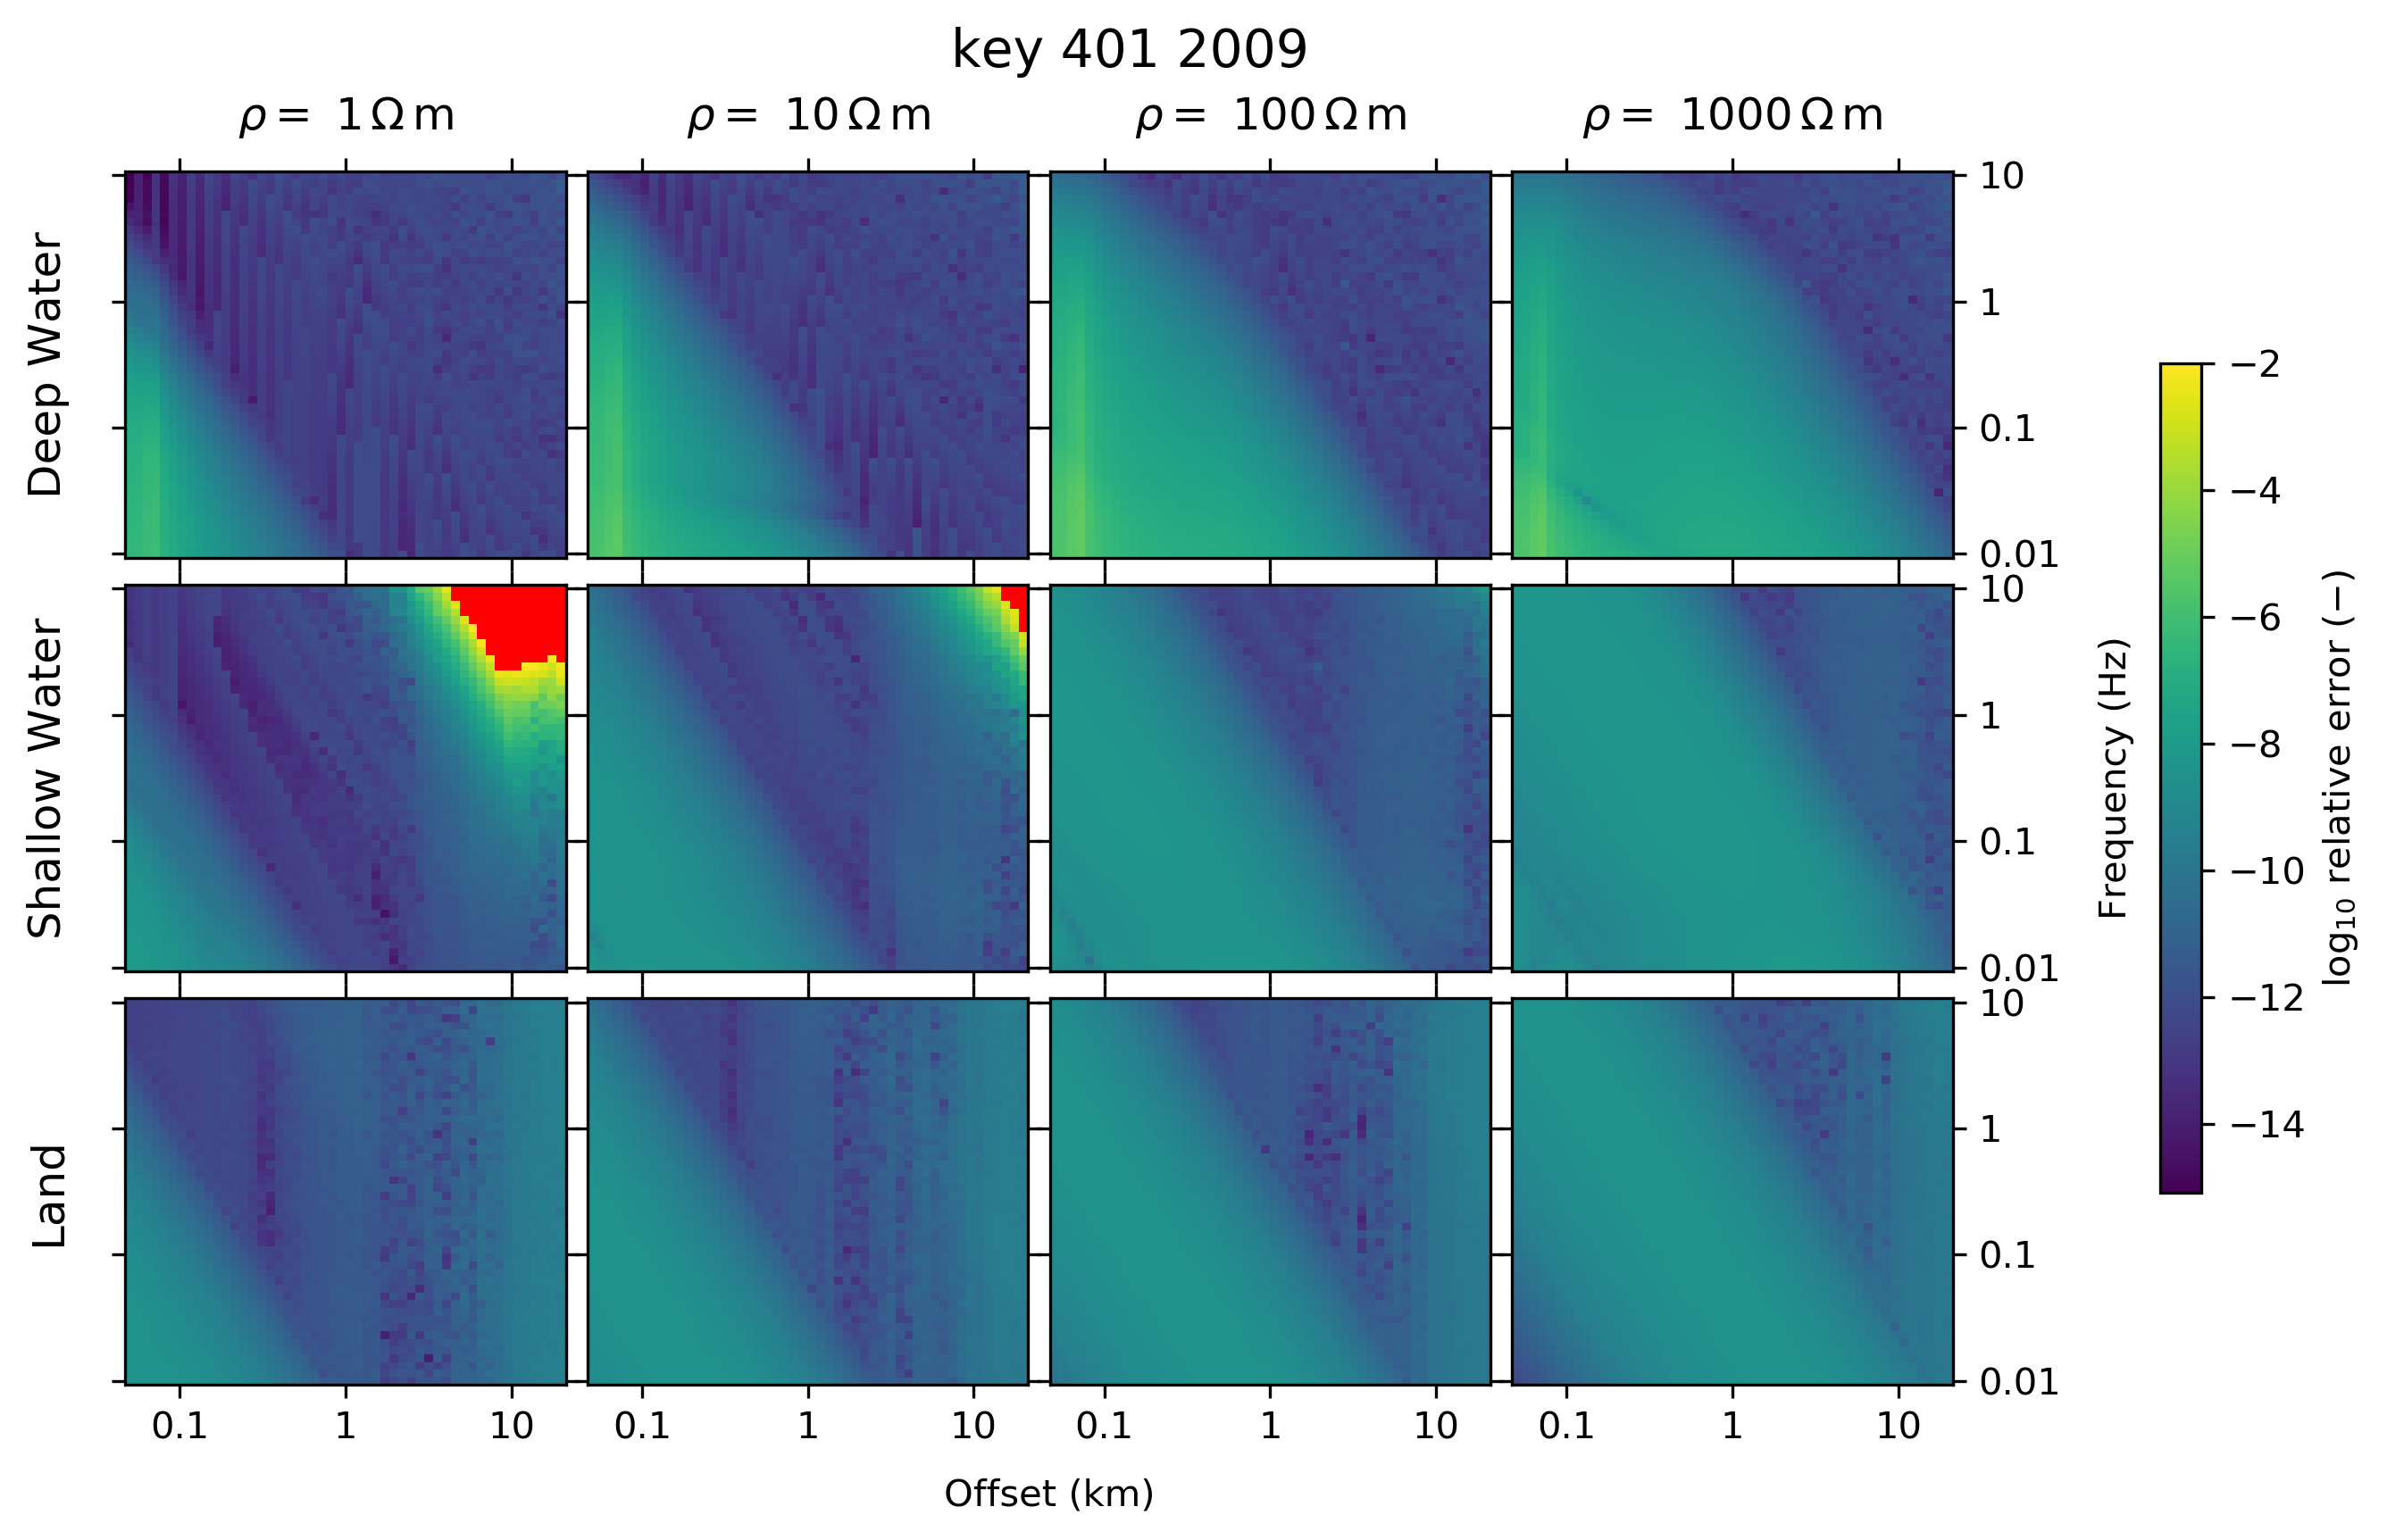

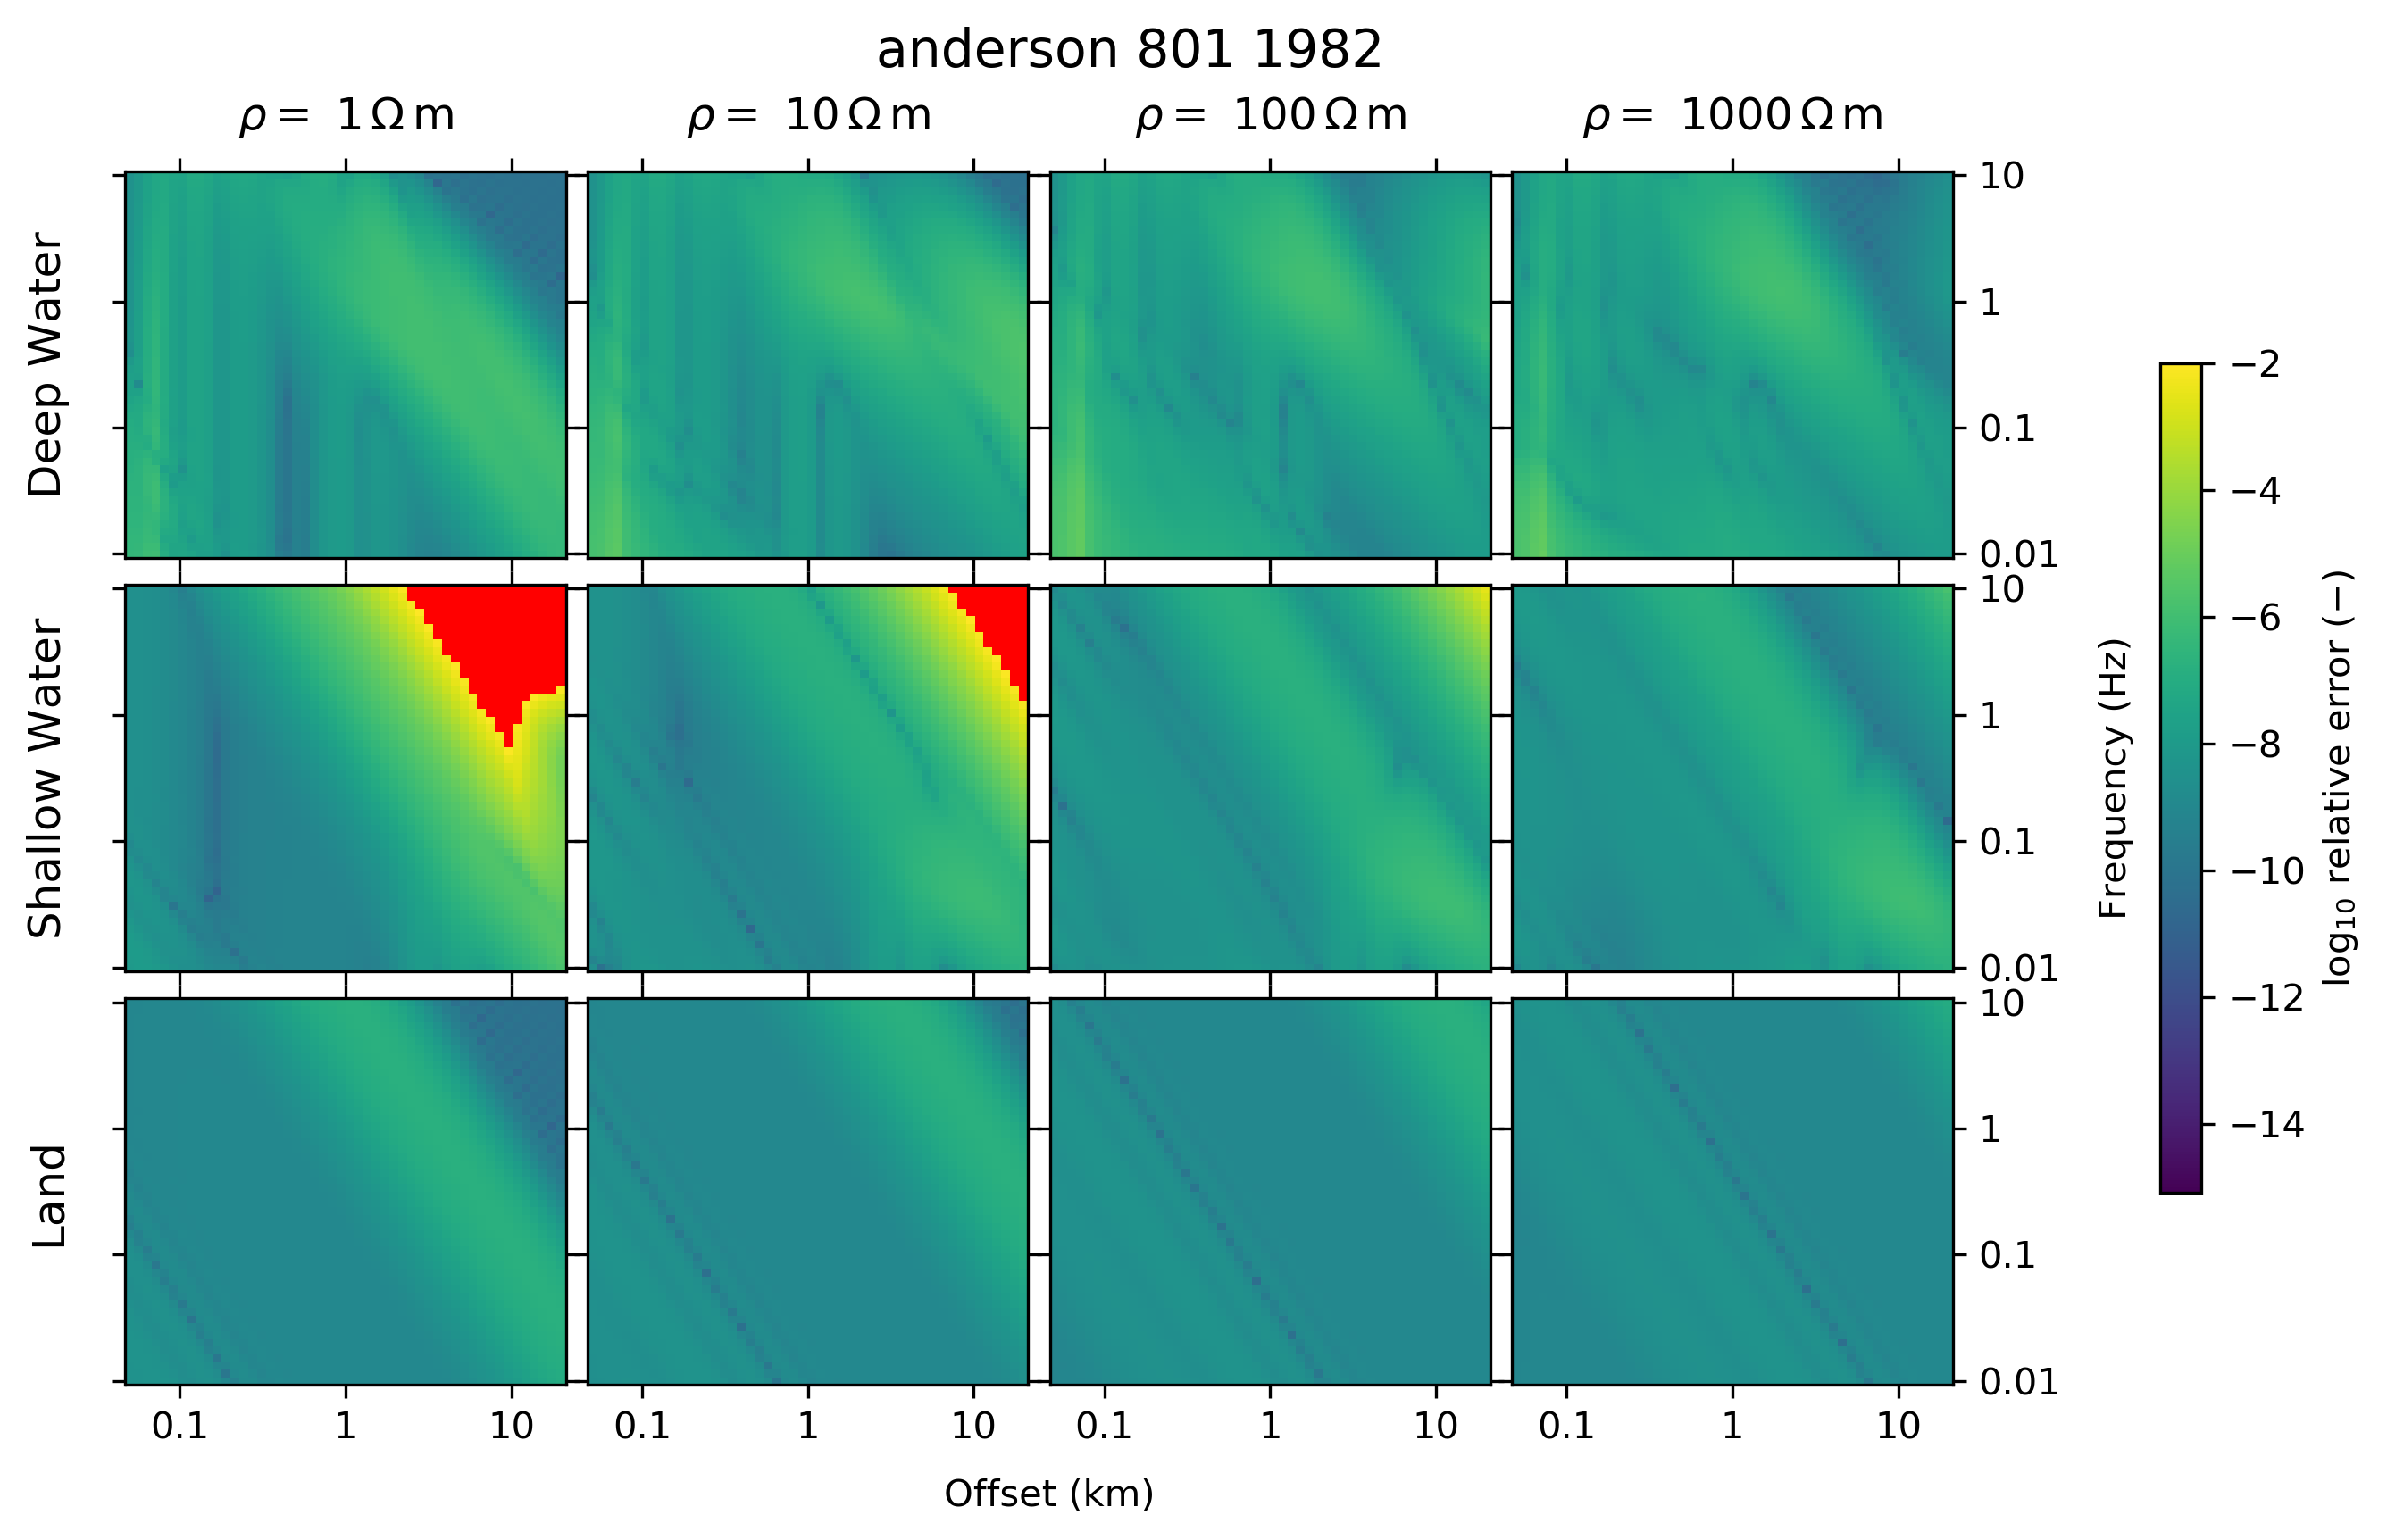

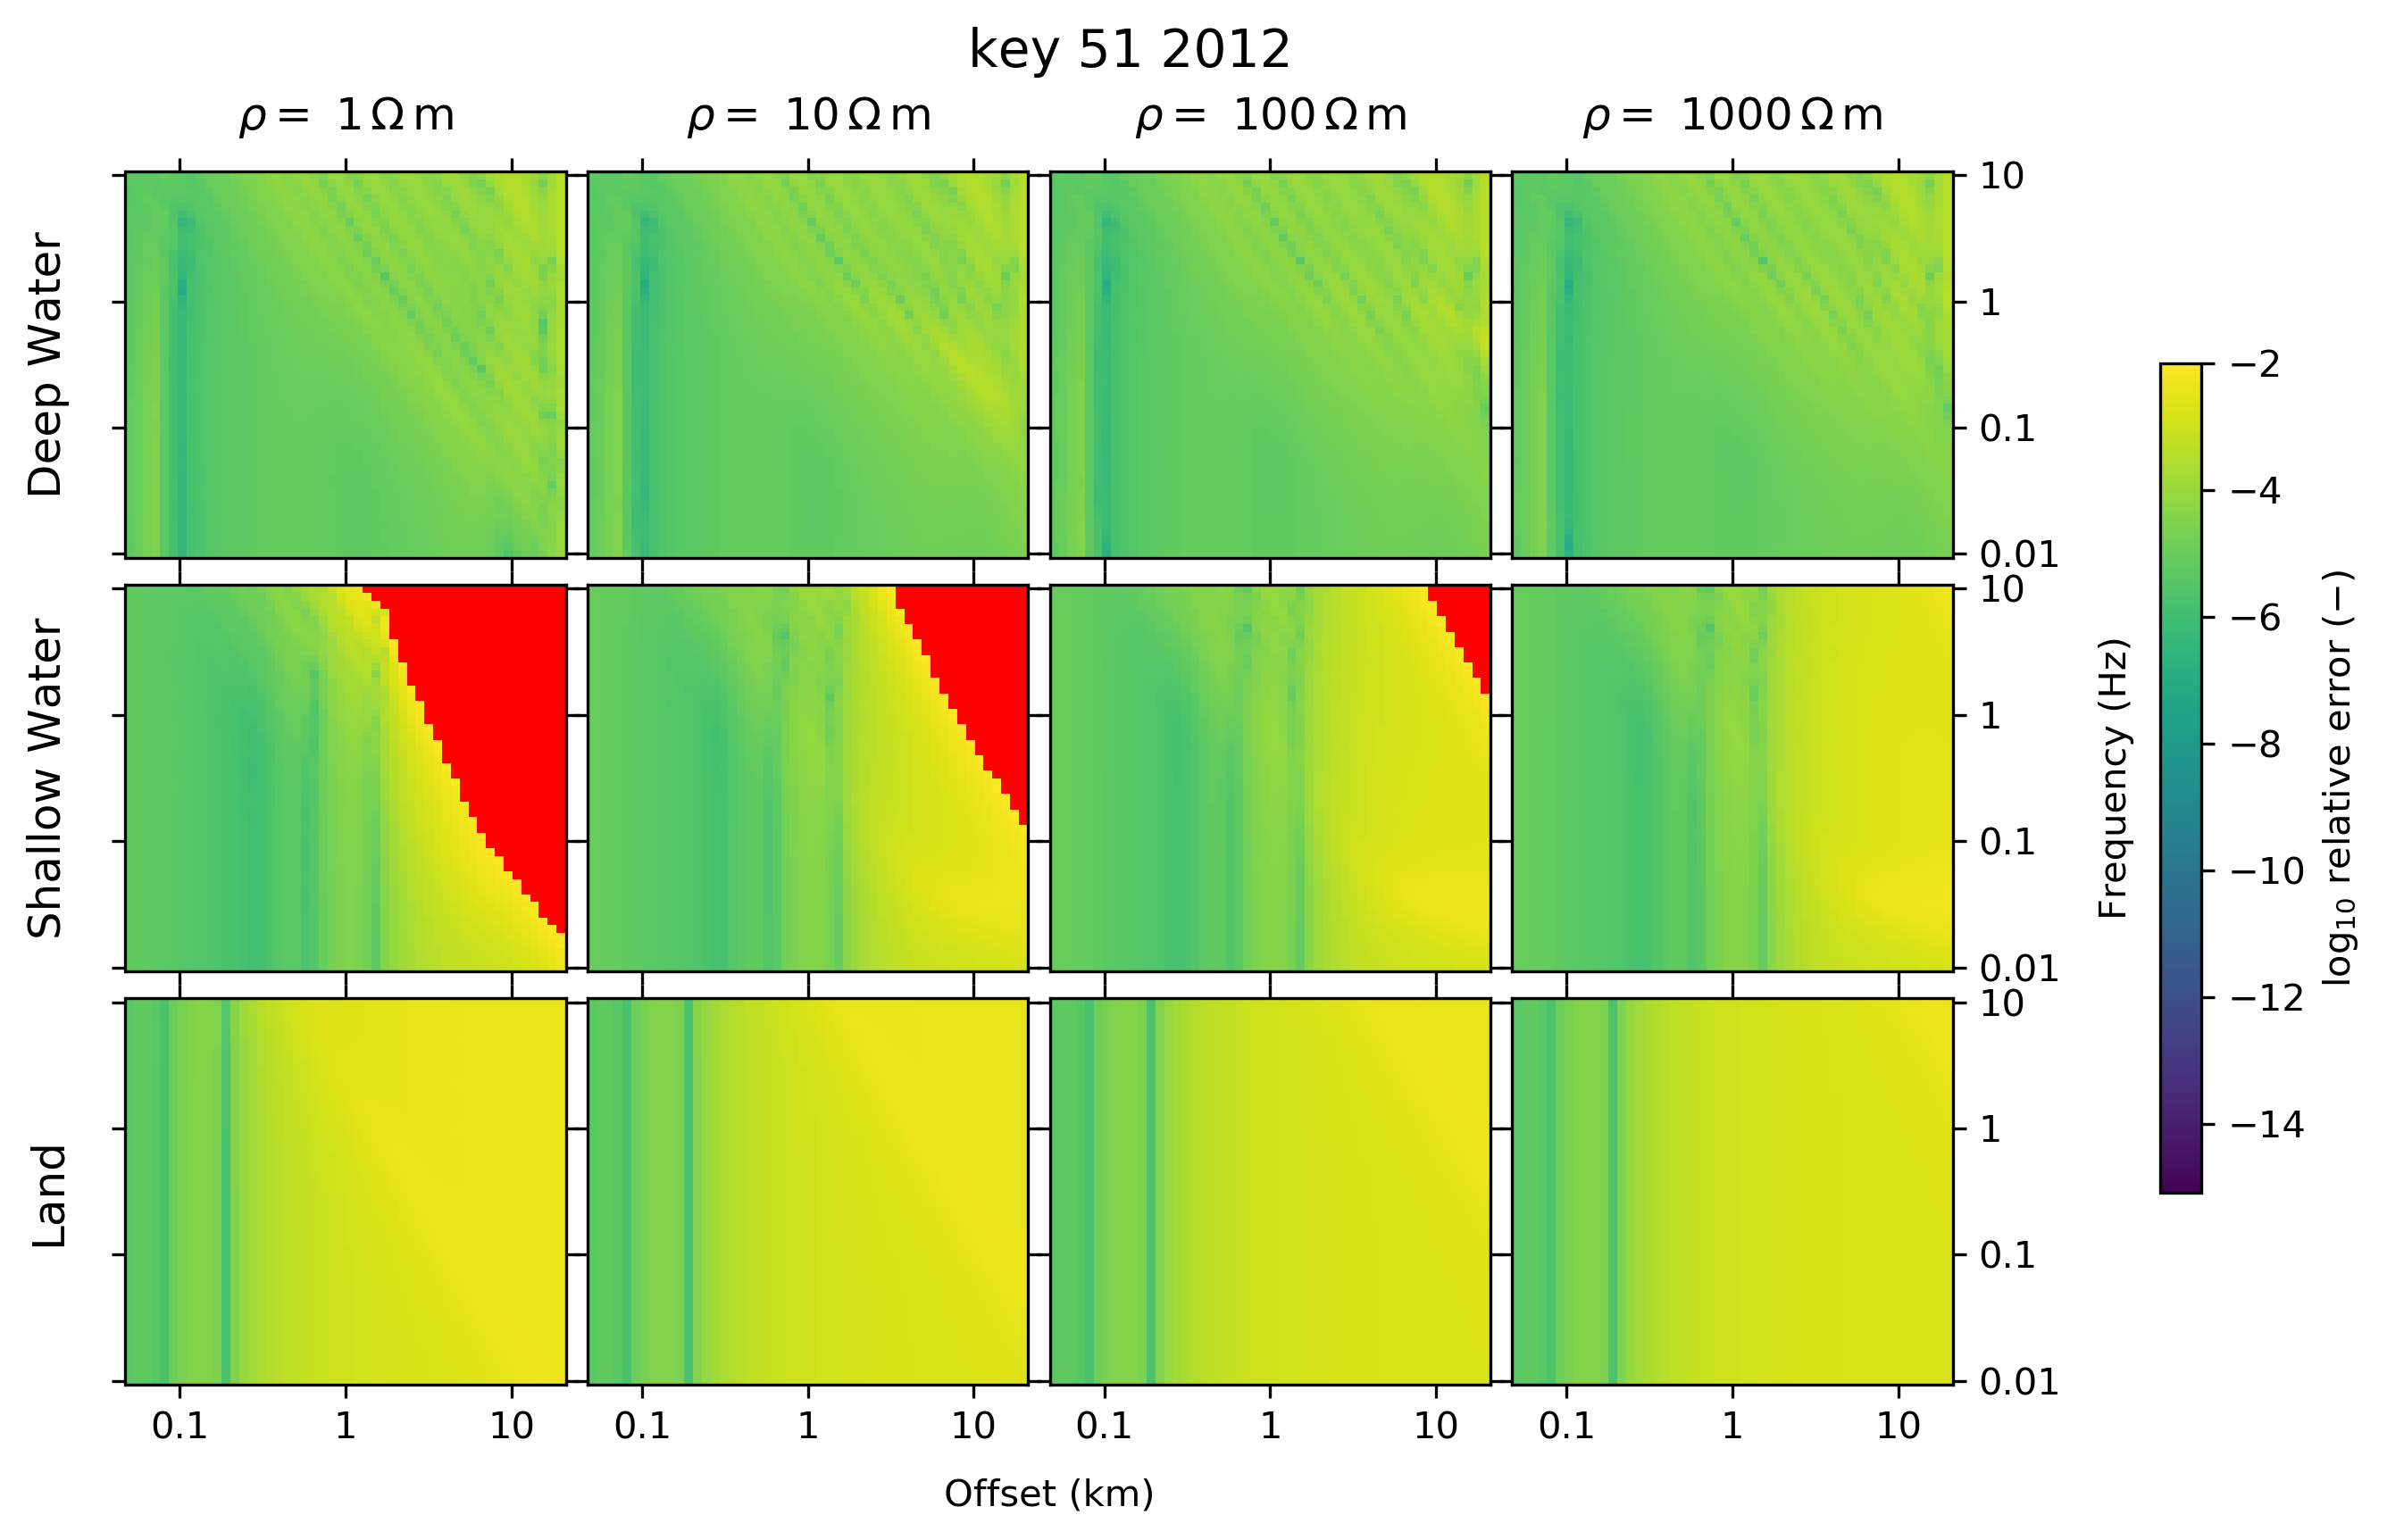

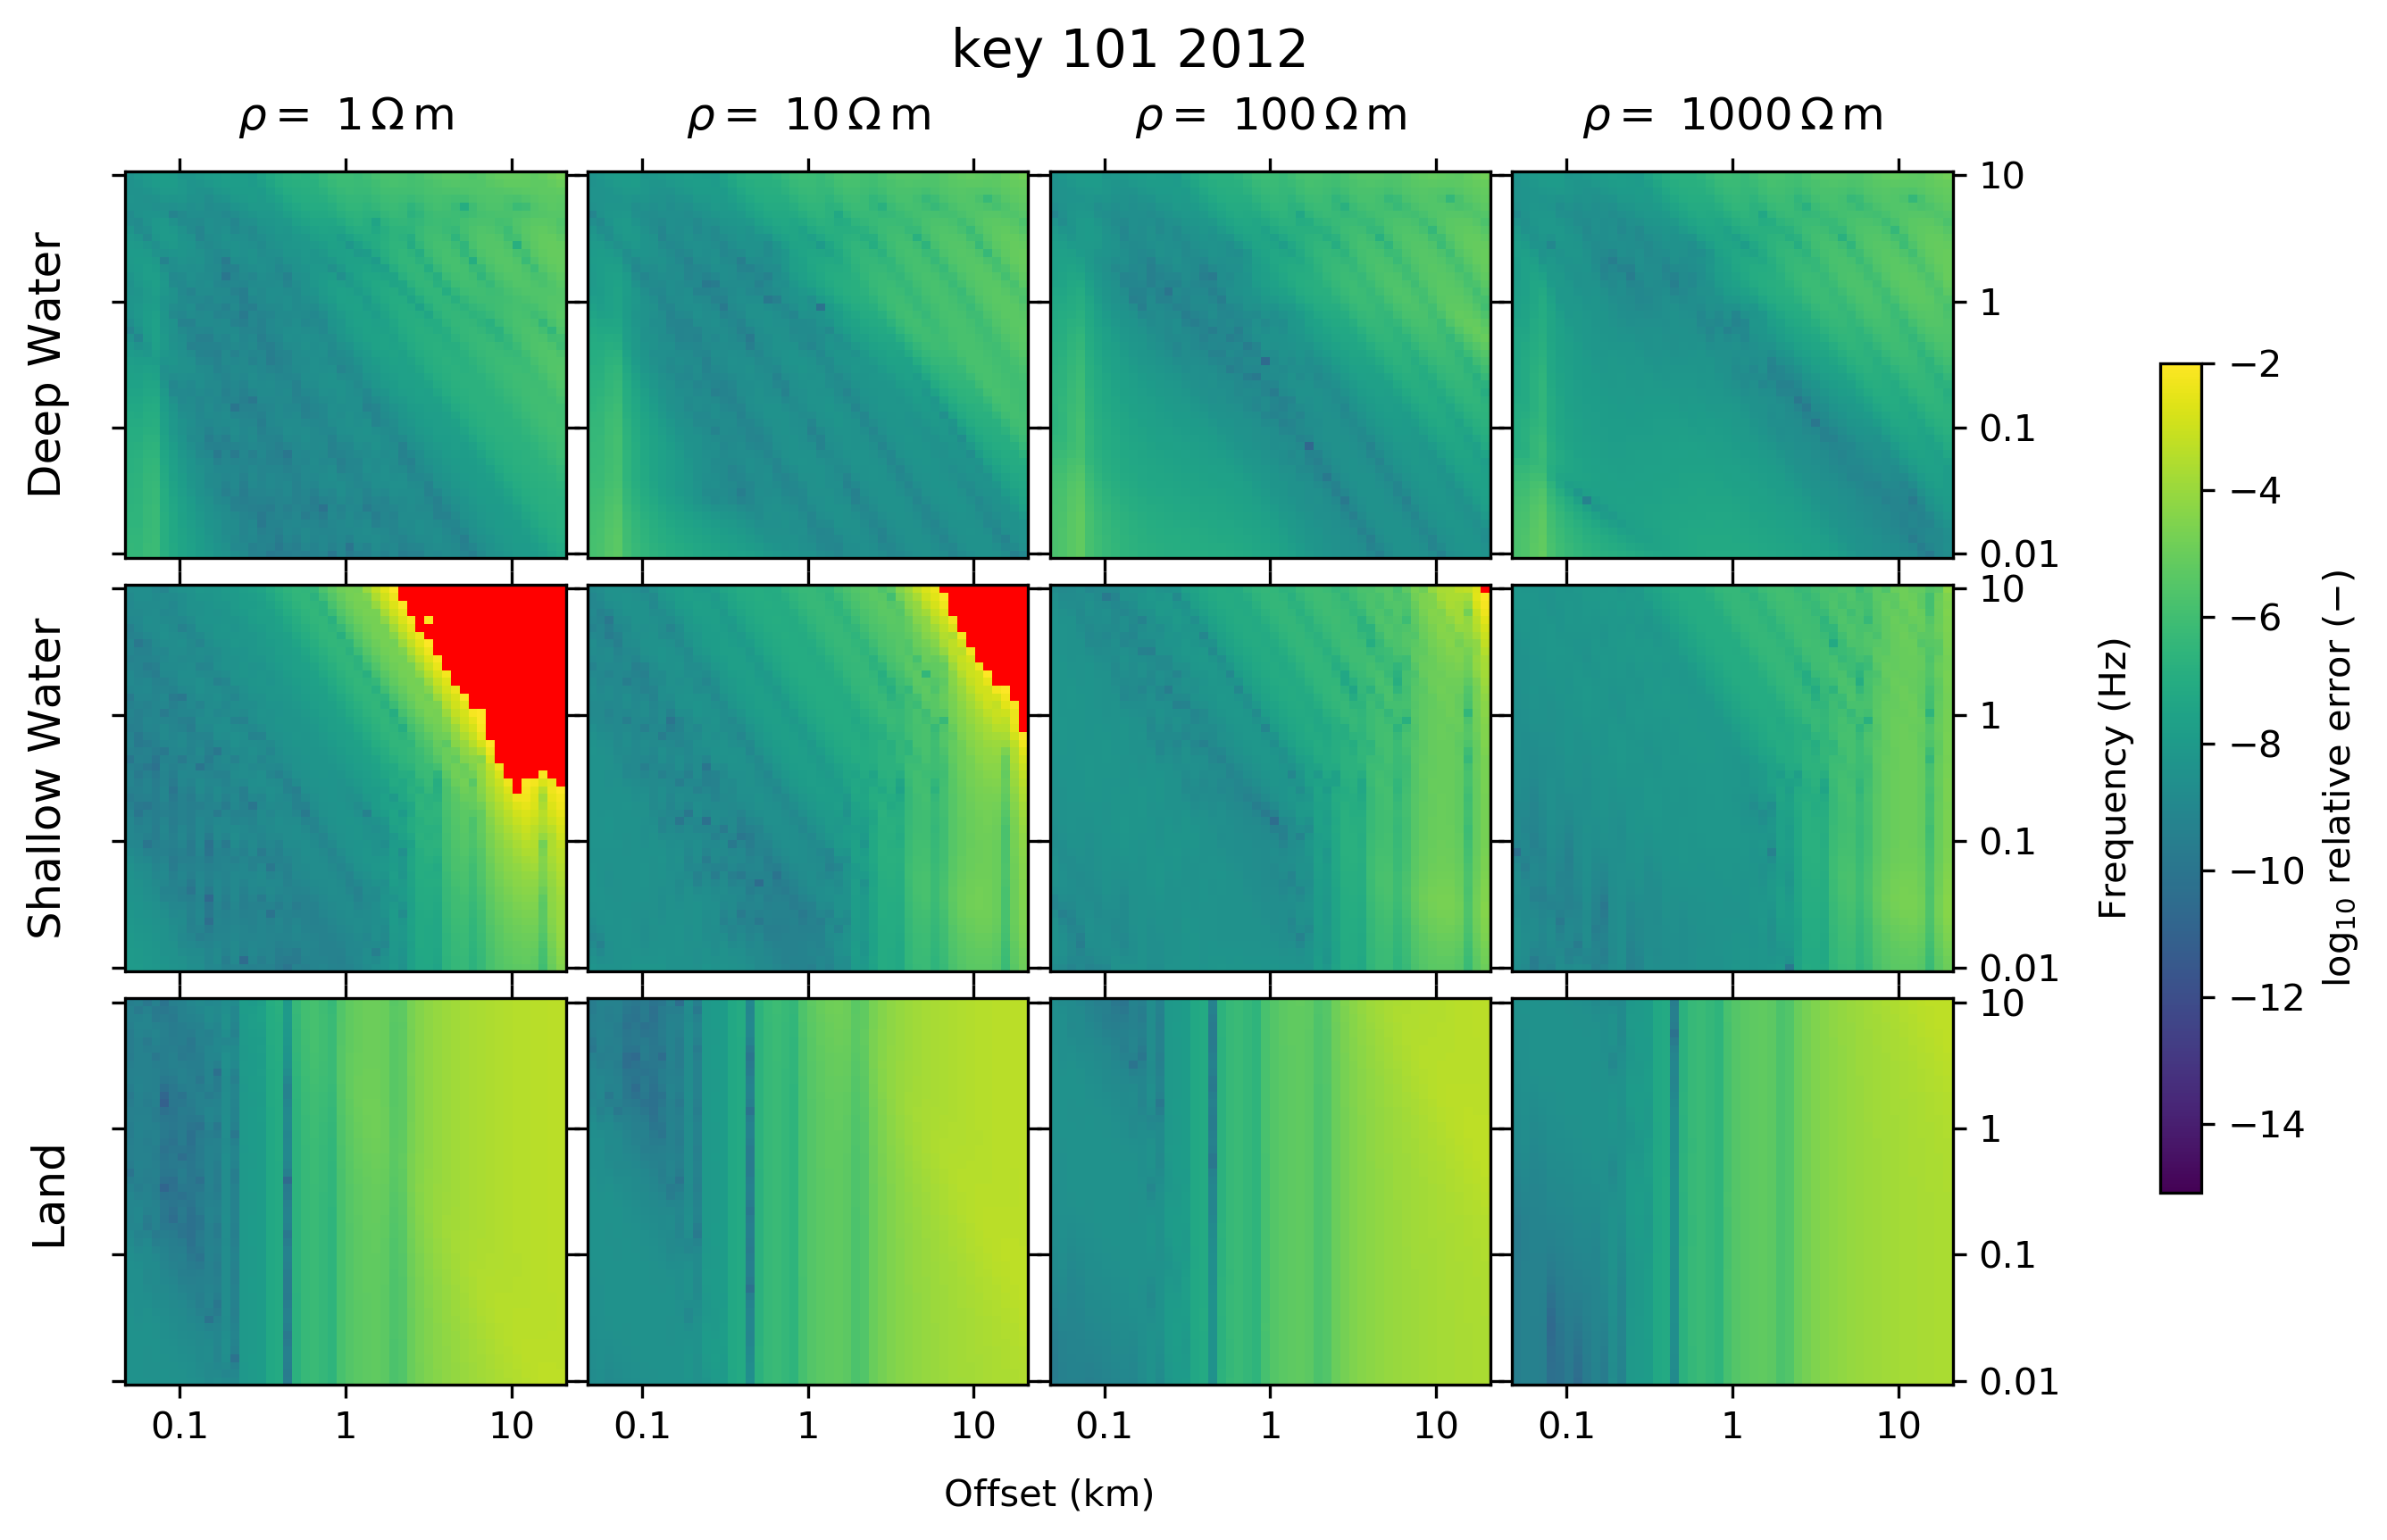

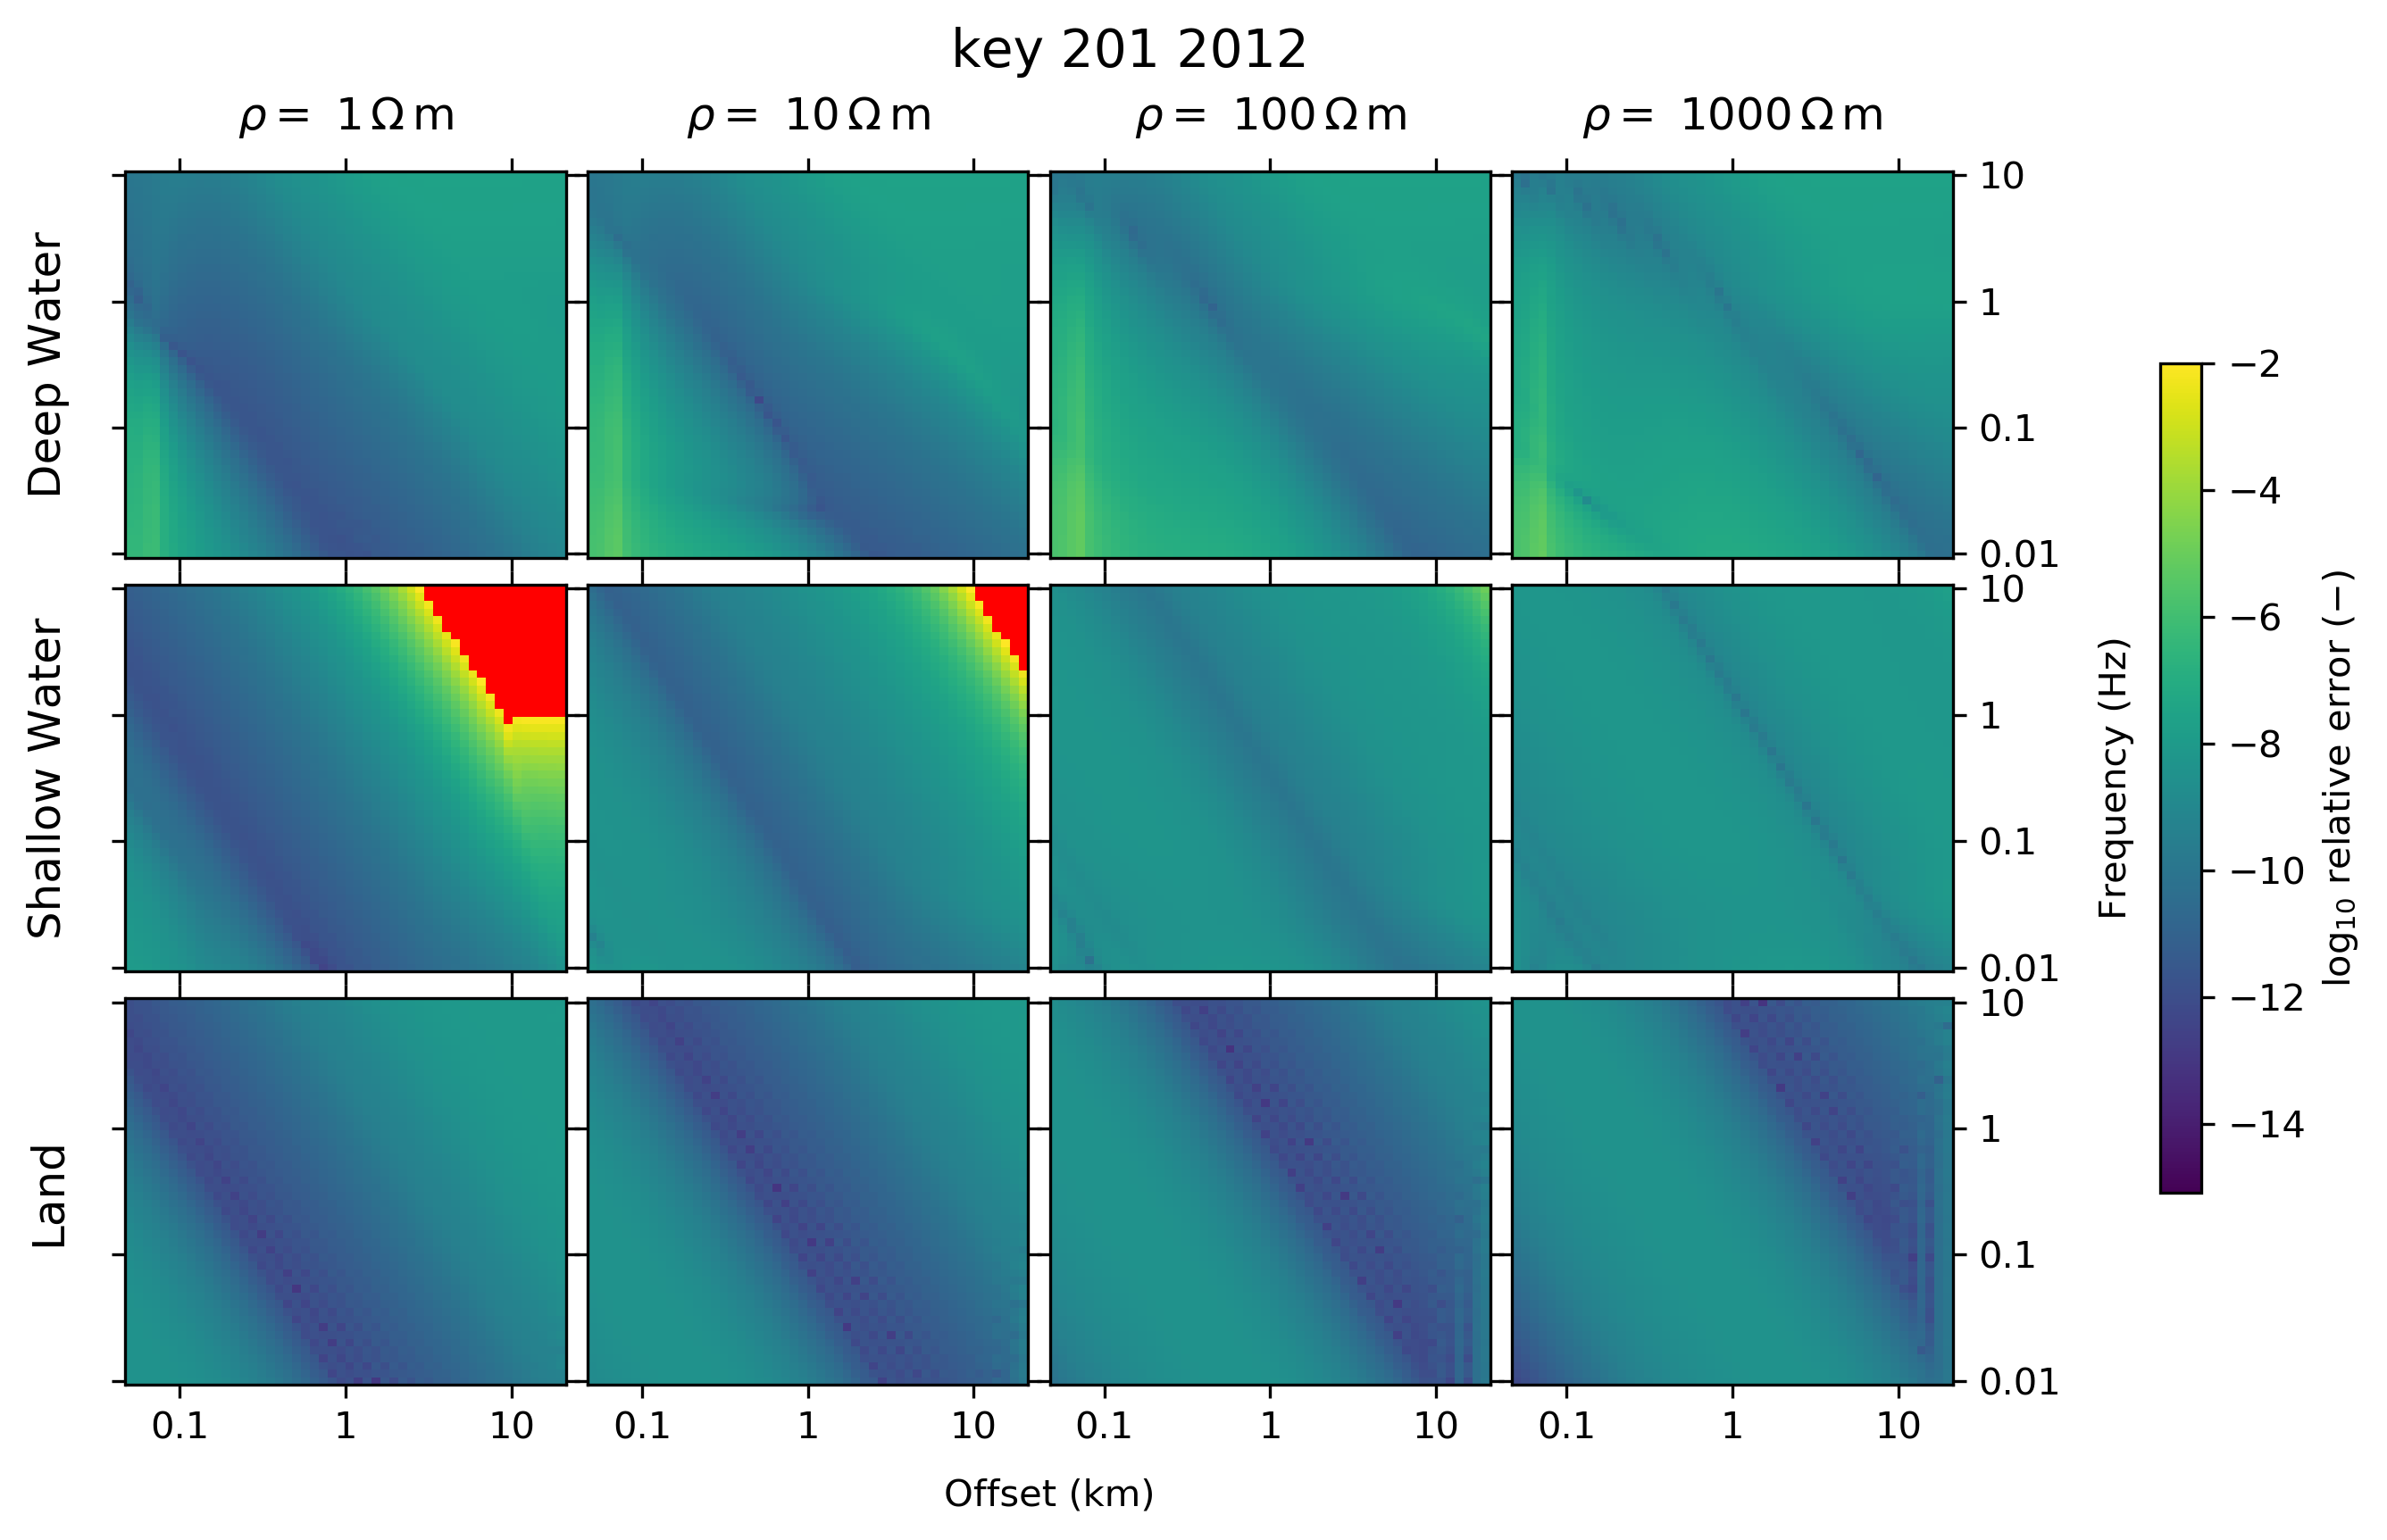

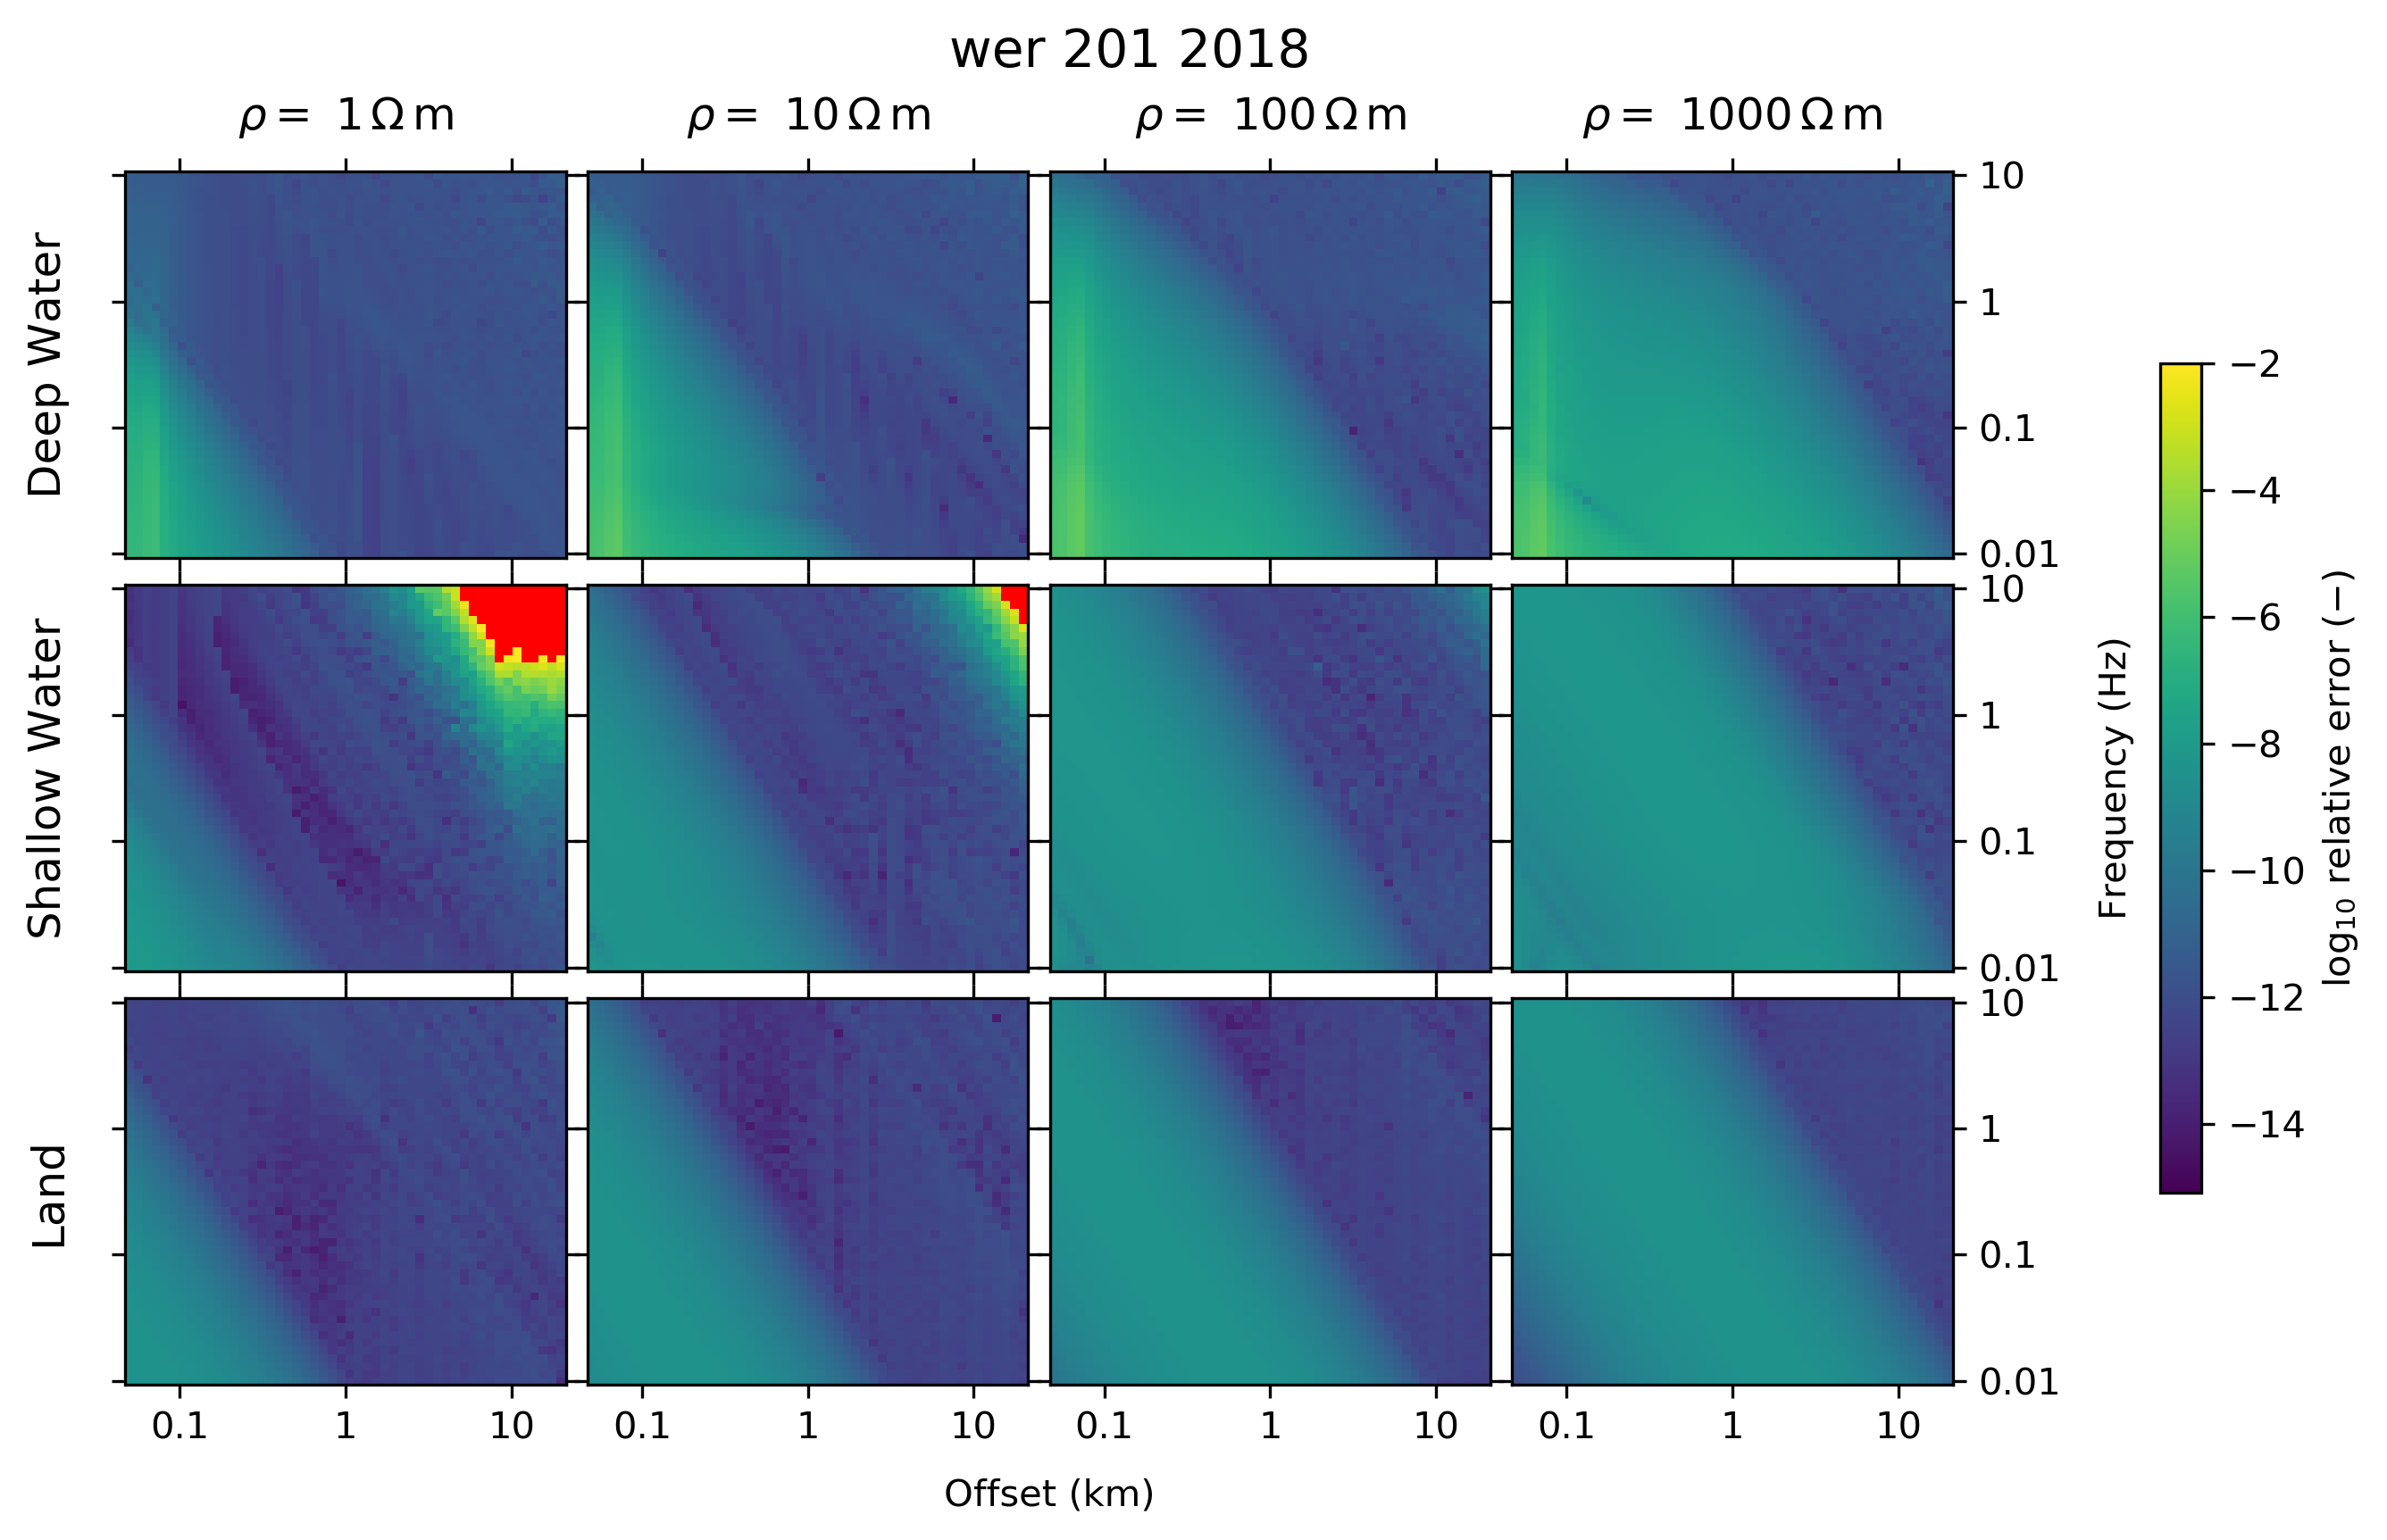

In [6]:
# Get min and max    
vmin = np.min(err)     # Take overall lowest value as minimum
vmax = -2              # Limit this to 1 % relative error
palette = plt.cm.viridis
palette.set_over('r', 1.0)  # Mark error > 1 % red

# General parameters
params = {'vmin': vmin, 'vmax': vmax, 'cmap': palette,
          'linewidth': 0, 'rasterized': True}

# Loop over filters
for fi, fname in enumerate(filt):
    
    # Start figure
    fig, axs = plt.subplots(figsize=(10, 6), nrows=3, ncols=4)
    plt.subplots_adjust(wspace=0.05, hspace=0.07)
    axs = axs.ravel()
    cplist = []

    # Loop over cases
    for i, name in enumerate(['Deep Water', 'Shallow Water', 'Land']):

        # Loop over resistivities
        for ii, ires in enumerate(res):
            plt.sca(axs[i*4+ii])

            # Plot result, store handle
            cp = plt.pcolormesh(xax, fax, err[fi, i, :, :, ii], **params)
            cplist.append(cp)

            # title
            if i == 0:
                plt.title(r'$\rho =$ '+str(ires)+r'$\,\Omega\,$m', fontsize=12, y=1.05)

            # x-ticks and labels
            if i == 2:
                plt.xticks([-1, 0, 1], ['0.1', '1', '10'])
            else:
                plt.xticks([-1, 0, 1], ())

            # y-label
            axs[i*4+ii].yaxis.tick_right()

            if ii == 3:
                plt.yticks([-2, -1, 0, 1], ['0.01', '0.1', '1', '10'])
                if i == 1:
                    axs[i*4+ii].yaxis.set_label_position("right")
                    plt.ylabel(r'Frequency (Hz)', labelpad=10)
            elif ii == 0:
                plt.ylabel(name, fontsize=12, labelpad=15)
                plt.yticks([-2, -1, 0, 1], ())
            else:
                plt.yticks([-2, -1, 0, 1], ())

            # Show ticks on all four sides
            axs[i*4+ii].xaxis.set_ticks_position('both')
            axs[i*4+ii].yaxis.set_ticks_position('both')

    # xlabel
    fig.text(0.47, 0.05, 'Offset (km)', ha='center')

    # Colorbar
    cax, kw = plt.matplotlib.colorbar.make_axes(axs,# location='bottom',
                                                fraction=.02, pad=0.1, aspect=20)
    cb = plt.colorbar(cplist[(i+1)*4-1], cax=cax, **kw)
    cb.set_label(r'$\log_{10}$ relative error ($-$)')#, labelpad=-40, y=1.05, rotation=0)

    # Title
    plt.suptitle(fname.replace('_', ' '), fontsize=14, y=0.97)

    # Save figure
    # plt.savefig('../figures/error-'+fname+'.pdf', bbox_inches='tight')

    plt.show()

In [7]:
epm.versions('HTML')